# Fitting a scaled LDA model via proximal gradient descent
_Date:_ October 3, 2024

**Background.**
Latent Dirichlet allocation (LDA) assumes that all words in a document are distributed with identical dispersion.

In many cases, however, the assumption of similar dispersion of all words in the vocabulary is unrealistic.
This is evidenced in the need to preprocess the input texts and remove highly used words such as articles (e.g. the, a) and conjunctions (e.g. and, for).

One way to account for the differences in dispersion in different words, while retaining the the interpretation of $\mathbf{\theta}$ as topics and $\beta_m$ as the topic usages in a document,
is to explicitly model different dispersions for the different words. We refer to this model as a scaled LDA model.

However, we find that the posterior updates on the simplex-constrained variables $\theta$ and $\beta$ are no longer Dirichlet-distributed.
Instead, they are Gamma distributed, with different rates. We use projected gradient descent to solve for the optimal parameter update under the Gamma objective, subject to the parameter being constrained to the simplex.

**Algorithm.** TODO

In [1]:
from functools import partial

import jax
from jax import jit, grad, lax, vmap
import jax.numpy as jnp
import jax.random as jr

from scipy.spatial.distance import cdist 
from scipy.optimize import linear_sum_assignment

from sklearn.decomposition import LatentDirichletAllocation as LDA

import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions

from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

/scratch/users/eyz/miniconda3/envs/dtd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Proximal gradient descent

### Generic PGD with backtracking line search

In [2]:
def prox_grad_descent(objective,
                      prox,
                      init_params,
                      max_num_steps=100,
                      max_num_backtrack_steps=100,
                      max_stepsize=1.0,
                      discount=0.9,
                      tol=1e-6,
                      verbosity=0):
    r""" Run proximal gradient descent on an objective using the given
    proximal operator.

    prox: params x stepsize -> new_params
    """
    # We need the gradient of the objective
    g = jit(objective)
    dg = jit(grad(objective))

    # Run proximal gradient descent until convergence
    def _step_cond(state):
        _, old_obj, curr_obj, counter = state
        return (abs(curr_obj - old_obj) > tol) & (counter <= max_num_steps)

    def _step_body(state):
        params, _, curr_obj, counter = state

        # Define the condition and body of a while loop for backtracking line search
        def _backtrack_cond(backtrack_state):
            stepsize, backtrack_counter = backtrack_state

            # Compute generalized gradient
            G = (params - prox(params - stepsize * dg(params), stepsize)) / stepsize

            # Update params and evaluate objective
            new_params = params - stepsize * G
            new_obj = g(new_params)

            # Compute upper bound on objective via quadratic Taylor approx
            lower_bound = g(params) \
                - stepsize * jnp.sum(dg(params) * G) \
                    + 0.5 * stepsize * jnp.sum(G**2)

            # Continue to decrease stepsize while objective exceeds lower bound
            return (new_obj > lower_bound) & (backtrack_counter < max_num_backtrack_steps)

        def _backtrack_body(backtrack_state):
            stepsize, backtrack_counter = backtrack_state
            return stepsize * discount, backtrack_counter + 1

        # Run backtracking line search to find stepsize
        stepsize, n_backtrack_steps = lax.while_loop(
            _backtrack_cond, _backtrack_body, (max_stepsize, 0)
        )

        # Perform update with this stepsize
        G = (params - prox(params - stepsize * dg(params), stepsize)) / stepsize
        new_params = params - stepsize * G
        new_obj = g(new_params)
        return new_params, curr_obj, new_obj, counter + 1

    params, _, _, n_steps = lax.while_loop(_step_cond, _step_body, (init_params, jnp.inf, 0.0, 0))
    return params

### Proximal operator to project onto the simplex

In [3]:
@jit
def _simplex_lagrangian(w, lmbda):
    return jnp.sum(jnp.clip(w - lmbda, a_min=0.0)) - 1.0


def bisect_jax(f, a, b, tol=1e-8, max_iter=1000):
    """Find a root of f via bisection.

    Args:
        f: a function that is monotonically increasing or decreasing on the interval [a, b]
        a: lower bound on root
        b: upper bound on root
    """
    def _bisect_cond(state):
        (a, f_a), (b, f_b), counter = state
        # m = (a + b) / 2
        return (abs(f(a)) > tol) & ((b - a) / 2 > tol) & (counter < max_iter)

    def _bisect_body(state):
        (a, f_a), (b, f_b), counter = state
        m = (a + b) / 2
        f_m = f(m)
        # if sign(f(m)) = sign(f(m)) then a <- m else b <- m // new interval
        state = lax.cond(jnp.sign(f_m) == jnp.sign(f_a),
                        lambda: ((m, f_m), (b, f_b), counter+1), # predicate true
                        lambda: ((a, f_a), (m, f_m), counter+1), # predicate false
                        )
        return state

    init_state = ((a, f(a)), (b, f(b)), 0)
    ((a, fa), (b, fb), counter) = lax.while_loop(_bisect_cond, _bisect_body, init_state)
    # print("num iters: ", counter)
    return a


def project_simplex(w, dummy_stepsize):
    """Project onto simplex following the approach in Ch 6.2.5 of
    https://web.stanford.edu/~boyd/papers/pdf/prox_algs.pdf
    """
    lmbda_max = jnp.max(w)
    lmbda_star = bisect_jax(partial(_simplex_lagrangian, w),
                            lmbda_max - 1, lmbda_max)
    return jnp.clip(w - lmbda_star, a_min=0.0)

In [4]:
# Test it on some inputs
for w in [
    jnp.array([0.2, 0.9, 1.4]),  # not on the simplex, positive inputs
    jnp.array([-0.4, 0.9, 0.2]),  # not on the simplex, negative inputs
    jnp.array([0.33, 0.33, 0.33]),  # simplex vector 
    jnp.array([3.3, 3.3, 3.3]),  # scaled version of a simplex vectro
]:
    what = project_simplex(w, 0)
    print(w, '->', what)
    assert jnp.all(what >= 0) & jnp.isclose(what.sum(), 1.0)

2024-10-03 13:46:47.310938: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


[0.2 0.9 1.4] -> [0.         0.25000006 0.75000006]
[-0.4  0.9  0.2] -> [0.         0.85       0.15000005]
[0.33 0.33 0.33] -> [0.33333337 0.33333337 0.33333337]
[3.3 3.3 3.3] -> [0.3333335 0.3333335 0.3333335]


### Minimize a sum of gamma negative log likelihoods

In [5]:
objective = lambda x, shapes, rates: \
    -1.0 * tfd.Gamma(shapes, rate=rates).log_prob(jnp.clip(x, a_min=1e-4)).sum()

First, we consider the special case of equal rates, $\beta \equiv \beta_i = \beta_j \forall i,j \in K$. In this case, the optimal parameter under both the Dirichlet and indepedent Gamma distributions are the same, up to a multiplicative constant. Specifically,
\begin{align*}
x_i^\star &\leftarrow \left(\arg\max_x \log \textrm{Dir}(x \mid \mathbf{\alpha})\right)_i = \frac{\alpha_i-1}{\sum_j (\alpha_j-1)} \\
y_i^\star &\leftarrow \left(\arg\max_y \log \textrm{Gamma}(x \mid \mathbf{\alpha}, \mathbf{\beta})\right)_i = \frac{\alpha_i-1}{\beta}.
\end{align*}
We also note that
$$
\frac{y_i^\star}{\sum_j y_j^\star} = \frac{\frac{\alpha_i-1}{\beta}}{\sum_j \frac{\alpha_j-1}{\beta}} = \frac{\alpha_i-1}{\sum_j (\alpha_j-1)} \equiv x_i^\star.
$$

In [6]:
shapes = jnp.array([2.0, 3.0, 4.0, 5.0])
K = len(shapes)
rates = jnp.ones(K) * 2.5

x0 = jnp.ones(K) / K
xstar = prox_grad_descent(lambda x: objective(x, shapes, rates),
                          project_simplex,
                          x0,
                          max_stepsize=1.0)

jnp.set_printoptions(precision=3)

print(f"shapes = {shapes}, rates = {rates}, x0={x0}")
print()
print("Gamma optimum:\t", (shapes-1)/rates)
print("Dir optimum:\t", (shapes - 1) / (shapes - 1).sum()) 
print('fitted optimum:\t',xstar)

shapes = [2. 3. 4. 5.], rates = [2.5 2.5 2.5 2.5], x0=[0.25 0.25 0.25 0.25]

Gamma optimum:	 [0.4 0.8 1.2 1.6]
Dir optimum:	 [0.1 0.2 0.3 0.4]
fitted optimum:	 [0.1 0.2 0.3 0.4]


In [7]:
shapes = jnp.array([2.0, 3.0, 4.0, 5.0])
K = len(shapes)
rates = 10 * jnp.ones(K)

x0 = jnp.ones(K) / K
xstar = prox_grad_descent(lambda x: objective(x, shapes, rates),
                          project_simplex,
                          x0,
                          max_stepsize=1.0)

jnp.set_printoptions(precision=3)


print(f"shapes = {shapes}, rates = {rates}, x0={x0}")
print()
print("Gamma optimum:\t", (shapes-1)/rates)
print("Dir optimum:\t", (shapes - 1) / (shapes - 1).sum()) 
print('fitted optimum:\t',xstar)

shapes = [2. 3. 4. 5.], rates = [10. 10. 10. 10.], x0=[0.25 0.25 0.25 0.25]

Gamma optimum:	 [0.1 0.2 0.3 0.4]
Dir optimum:	 [0.1 0.2 0.3 0.4]
fitted optimum:	 [0.1 0.2 0.3 0.4]


However, when the independent Gamma variables have different rates, we note that the optimums under the different distributions are different.
\begin{align*}
x_i^\star &\leftarrow \left(\arg\max_x \log \textrm{Dir}(x \mid \mathbf{\alpha})\right)_i = \frac{\alpha_i-1}{\sum_j (\alpha_j-1)} \\
y_i^\star &\leftarrow \left(\arg\max_y \log \textrm{Gamma}(x \mid \mathbf{\alpha}, \mathbf{\beta})\right)_i = \frac{\alpha_i-1}{\beta_i}.
\end{align*}

Moreover, note that $z^\star \leftarrow \textrm{PGD}$ does _not_ necessarily reults in either $x^\star$ or $y^\star$. It seems to find a solution in between $x^\star$ and $\textrm{proj}(y^\star)$.

In [8]:
shapes = jnp.array([2.0, 3.0, 4.0, 5.0])
K = len(shapes)
rates = jnp.array([1.0, 2.0, 3.0, 4.0])

x0 = jnp.ones(K) / K
xstar = prox_grad_descent(lambda x: objective(x, shapes, rates),
                          project_simplex,
                          x0,
                          max_stepsize=0.1)
jnp.set_printoptions(precision=3)

print(f"shapes = {shapes}, rates = {rates}, x0={x0}")
print()
print("Gamma optimum:\t", (shapes-1)/rates)
print("Dir optimum:\t", (shapes-1) / (shapes - 1).sum()) 
print('fitted optimum:\t',xstar)

shapes = [2. 3. 4. 5.], rates = [1. 2. 3. 4.], x0=[0.25 0.25 0.25 0.25]

Gamma optimum:	 [1. 1. 1. 1.]
Dir optimum:	 [0.1 0.2 0.3 0.4]
fitted optimum:	 [0.123 0.22  0.297 0.36 ]


We can check that this point is indeed the optimum along each slice of the simplex. We fix all but two dimensions of the $x^\star$, then plot the objective.

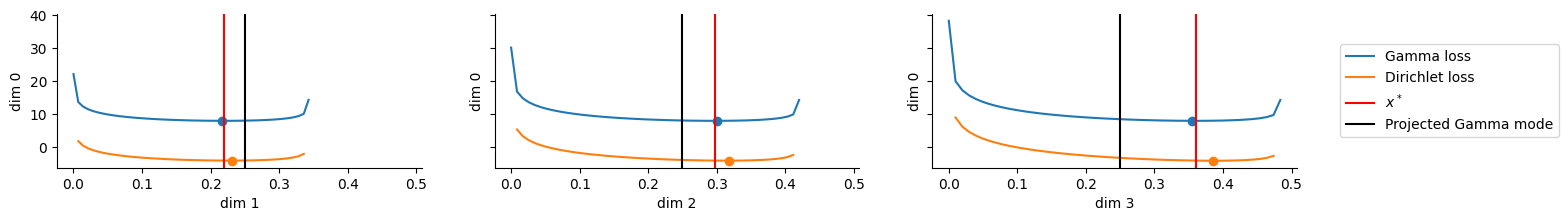

In [9]:
dim = xstar.shape[-1]
n_points = 50

fig, axs = plt.subplots(nrows=1, ncols=dim-1, sharex=True, sharey=True, figsize=(16,2))

dirichlet_objective  = lambda x, shapes, _: -1 * tfd.Dirichlet(shapes).log_prob(x)

for ax, dx in zip(axs, range(1,dim)):
    # vary x-star along two axes
    thr = 1 - xstar[jnp.array([d for d in range(1,dim) if d != dx])].sum()
    vs = jnp.linspace(0, thr, num=n_points)
    test_xs = jnp.tile(xstar, (n_points, 1))
    test_xs = test_xs.at[:, dx].set(vs)
    test_xs = test_xs.at[:, 0].set(thr - vs)
    assert jnp.allclose(test_xs.sum(axis=-1), 1.0)

    # Plot Gamma objective
    nll = jnp.array([objective(x, shapes, rates) for x in test_xs])
    xmin = vs[jnp.argmin(nll)]
    ax.plot(vs, nll, label="Gamma loss")
    ax.scatter(xmin, nll.min())

    # Plot Dirichlet objective
    nll = jnp.array([dirichlet_objective(x, shapes, rates) for x in test_xs])
    xmin = vs[jnp.argmin(nll)]
    ax.plot(vs, nll, label="Dirichlet loss")
    ax.scatter(xmin, nll.min())

    # Plot fitted optimum
    ax.axvline(xstar[dx], color='r', label=r"$x^*$")
    ax.set_xlabel(f"dim {dx}")
    ax.set_ylabel(f"dim {0}")

    # Plot gamma objective
    gamma_star = project_simplex((shapes-1)/rates, 1.0)
    ax.axvline(gamma_star[dx], color='k', label='Projected Gamma mode')

    ax.spines[['top', 'right']].set_visible(False)

axs[-1].legend(loc='center left', bbox_to_anchor=[1.1,0.5])

## Scaled LDA

Using the PGD method should find parameters exactly equivalent to the standard LDA algorithm.

### Generate data

In [10]:
from collections import namedtuple
from typing import Optional, Sequence
from jax.typing import ArrayLike
from jax import Array

KeyArray = Array

Params = namedtuple("Params", [
    "topics", "weights", "scales", "scounts"
    ], defaults=(None, None)
)
PriorParams = namedtuple("PriorParams", [
    "topic_conc", "weight_conc", "scale_conc", "scount_conc",
    "topic_rate", "weight_rate", "scale_rate", "scount_rate",
    ], defaults=(1.00, 1.00, 1.00, 1.00, 1e-4, 1e-4, 1e-4, 1e-4)
)

def sample_params_and_data(seed: KeyArray,
                           n_topics: int,
                           vocab_size: int,
                           n_docs: int,
                           doc_length_rate: float,
                           topic_conc: float=1.001,
                           weight_conc: float=1.001,
                           scale_conc: float=1.001) -> tuple[Params, Array]:
    """Sample parameters and generate data."""
        
    s1, s2, s3, s4, s5 = jr.split(seed, 5)

    # Sample topics, shape (n_topics, vocab_size)
    alpha_ = jnp.broadcast_to(jnp.asarray(topic_conc, dtype=float), (vocab_size,),)
    topics = jr.dirichlet(s1, alpha_, shape=(n_topics,))

    # Sample doc-topic weights, shape (n_docs, n_topics)
    alpha_ = jnp.broadcast_to(jnp.asarray(weight_conc, dtype=float), (n_topics,))
    weights = jr.dirichlet(s2, alpha_, shape=(n_docs,))
    
    # Sample word scales, shape (vocab_size,)
    alpha_ = jnp.broadcast_to(jnp.asarray(scale_conc, dtype=float), (vocab_size,))
    scales = jr.dirichlet(s3, alpha_, shape=())

    # Sample document lengths, shape (n_docs,)
    lengths = jr.poisson(s4, doc_length_rate, (n_docs,))
    lengths = jnp.asarray(lengths, dtype=float)  # tfd.Multinomial expects float dtype, but value still need to be integer valued
    
    # Sample data, shape (n_docs, vocab_size)
    rates = (scales * (weights @ topics))
    probs = rates / rates.sum(axis=-1, keepdims=True)
    data = tfd.Multinomial(lengths, probs=probs).sample((), s5)

    # Calculate scaled-counts, which is parameter that the inference model infers
    scounts = lengths / rates.sum(axis=-1)

    return Params(topics, weights, scales, scounts,), data

# ========================================================================================

n_topics = 3
vocab_size = 5
n_docs = 5000
doc_length_rate = 1000  # expected document length

seed = jr.key(32)
true_params, data = sample_params_and_data(
    seed, n_topics, vocab_size, n_docs, doc_length_rate=doc_length_rate
)

Text(0.5, 1.15, 'Scaled LDA')

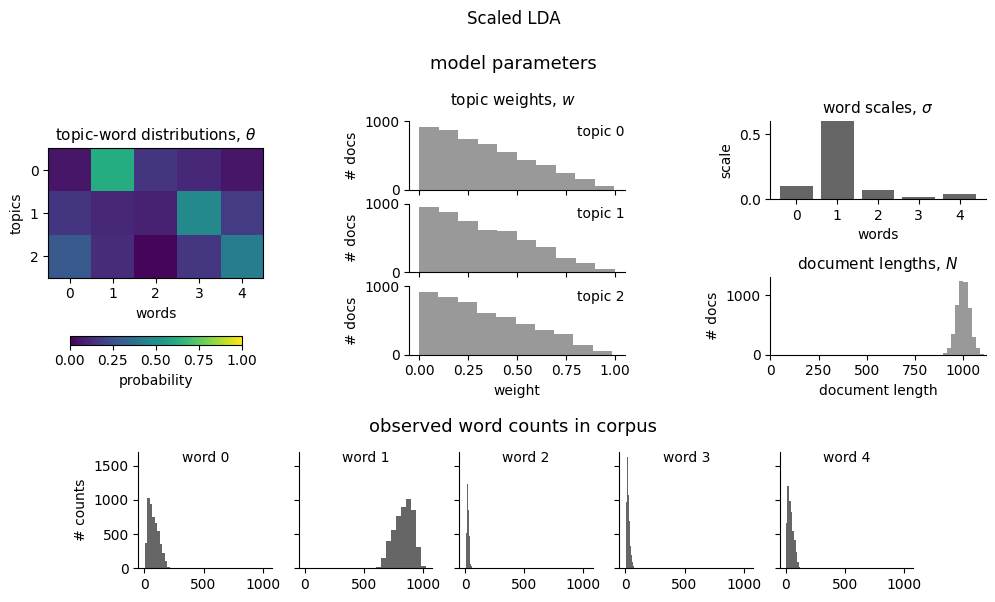

In [11]:
def plot_model_param_and_data(params: Params, data: Array):
    subfig_title_size = 13
    subfig_title_y = 1.1
    subplot_title_size = 11

    fig = plt.figure(figsize=(10,5))
    subfigs = fig.subfigures(2, 1, height_ratios=[2,1], hspace=0.2)

    # ===========================
    # Row 1: Model params
    # ===========================
    subfigs[0].suptitle('model parameters', y=subfig_title_y, fontsize=subfig_title_size)
    param_subfigs = subfigs[0].subfigures(1, 3, wspace=0.3)

    # ---------------------------
    # Topics
    # ---------------------------
    ax = param_subfigs[0].subplots()

    im = ax.imshow(params.topics, vmin=0, vmax=1)
    plt.colorbar(
        im, ax=ax, label='probability', location='bottom', pad=0.25, fraction=0.08, shrink=0.8
    )

    ax.set_xlabel('words'); ax.set_xticks(range(vocab_size))
    ax.set_ylabel('topics'); ax.set_yticks(range(n_topics))
    ax.set_title(r'topic-word distributions, $\theta$', fontsize=subplot_title_size)

    # ---------------------------
    # Weights
    # ---------------------------
    axs = param_subfigs[1].subplots(n_topics, sharex='all', sharey='all')
    for k, ax in enumerate(axs):
        ax.hist(params.weights[:,k], fc='0.6')
        ax.text(1, 0.95, f"topic {k}", transform=ax.transAxes, ha='right', va='top')
        ax.set_ylabel('# docs')
        sns.despine(ax=ax)
        
    axs[-1].set_xlabel('weight')
    param_subfigs[1].suptitle(r'topic weights, $w$', fontsize=subplot_title_size)

    # ---------------------------
    # Word scales and doc lengths
    # ---------------------------
    axs = param_subfigs[2].subplots(2, gridspec_kw={'hspace': 1.0})

    ax = axs[0]
    ax.bar(range(vocab_size), params.scales, fc='0.4')
    ax.set_xlabel('words'); ax.set_xticks(range(vocab_size))
    ax.set_ylabel("scale"); ax.set_ylim(top=3/vocab_size)
    sns.despine(ax=ax)
    ax.set_title(r'word scales, $\sigma$', fontsize=subplot_title_size)

    ax = axs[1]
    ax.hist(data.sum(axis=-1), fc='0.6')
    ax.set_xlabel('document length')
    ax.set_xlim(left=0)
    ax.set_ylabel('# docs')
    sns.despine(ax=ax)
    ax.set_title(f'document lengths, $N$', fontsize=subplot_title_size)

    # ===========================
    # Row 2: Word usage counts
    # ===========================
    ncols = 5
    nrows = vocab_size // ncols + (vocab_size % ncols)

    subfigs[1].suptitle('observed word counts in corpus', y=subfig_title_y, fontsize=subfig_title_size)
    axs = subfigs[1].subplots(nrows, ncols, sharex='all', sharey='all')

    for v, ax in enumerate(axs.ravel()):
        ax.hist(data[:,v], fc='0.4')
        ax.text(0.5, 0.95, f"word {v}", transform=ax.transAxes, ha='center', va='center')
        sns.despine(ax=ax)
    axs[0].set_ylabel('# counts')

    return fig

# ----------------------------------------------------------------------------------------
fig = plot_model_param_and_data(true_params, data)
fig.suptitle(f'Scaled LDA', y=1.15)

**Figure.** Model parameters and observed word counts of scaled LDA model.
The `word_scale_conc` concentrations are explicitly set to be adversarial:
We see that topic 1 has large mass on word 1, but word 1 makes up a significantly less fraction of observed words
than, for example, words 2, 3, and 4.

### Infer parameters with variational Bayes

In [12]:
# Infer with variational Bayes (VB)
from sklearn.decomposition import LatentDirichletAllocation as LDA

lda = LDA(n_topics,)

lda.fit(data)

topics=lda.components_ / lda.components_.sum(axis=1, keepdims=True)
weights=lda.transform(data)

# ----------------------------------------------------------------------
# Permute VB topics to best match data-generating topics.
# Use Jensen-Shannon divergence (smoothed and symmetrized version of KL div,
# bounded between 0 and 1). Good enough for our purposes
cost_matrix = cdist(true_params.topics, topics, metric='jensenshannon')
_, i_permute = linear_sum_assignment(cost_matrix)

vb_params = Params(
    topics = topics[i_permute],
    weights = weights[:,i_permute],
)

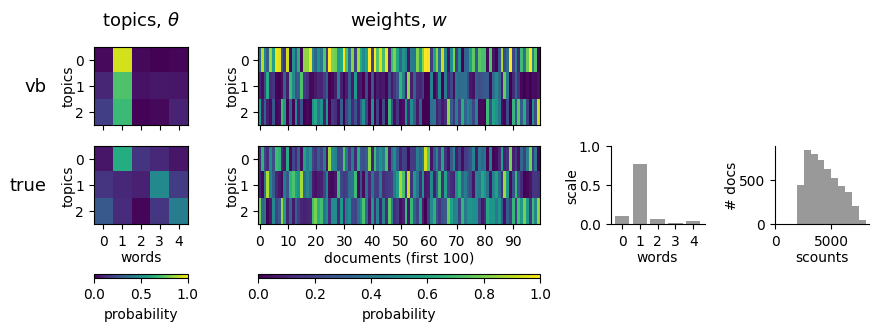

In [13]:
def compare_params(params_dict, fig=None):
    for params in params_dict.values():
        n_params = len(params)
        n_topics, vocab_size = params.topics.shape
        n_docs = len(params.weights)
        break
    
    n_sets = len(params_dict)

    if fig is None:
        fig, all_axs = plt.subplots(
            nrows=n_sets+2, height_ratios=(1,)*n_sets + (0.1,0.05),
            ncols=n_params, width_ratios=(1,3,1,1),
            gridspec_kw={"hspace": 0.5, "wspace": 0.5},
            figsize=(10,len(params_dict)+1)
        )
    else:
        all_axs = fig.axes

    # Second to last axis is just to a buffer pad
    for ax in all_axs[-2]:
        ax.remove()

    # ======================================================
    # Topics (heatmap)
    # ======================================================
    i_col = 0
    axs, cax = all_axs[:-2,i_col], all_axs[-1,i_col]

    for ax, params in zip(axs, params_dict.values()):
        n_topics, vocab_size = params.topics.shape
        im = ax.imshow(params.topics, vmin=0, vmax=1, aspect="auto")
        ax.set_xticks(range(vocab_size)); ax.tick_params(labelbottom=False)
        ax.set_ylabel("topics", labelpad=0); ax.set_yticks(range(n_topics))
    ax.set_xlabel("words", labelpad=2); ax.tick_params(labelbottom=True)

    # Show colorbar
    plt.colorbar(im, cax=cax, location='bottom', label='probability')

    # ======================================================
    # Weights (heatmap)
    # ======================================================
    i_col = 1
    axs, cax = all_axs[:-2,i_col], all_axs[-1,i_col]

    n = 100
    for ax, params in zip(axs, params_dict.values()):
        n_docs, n_docs = params.weights.shape
        im = ax.imshow(params.weights[:n].T, vmin=0, vmax=1, aspect="auto", interpolation="none")
        
        ax.set_xticks(jnp.linspace(0, n, num=min(10, n), endpoint=False)); ax.tick_params(labelbottom=False)
        ax.set_ylabel("topics", labelpad=0); ax.set_yticks(range(n_topics))

    ax.set_xlabel(f"documents (first {n})", labelpad=2); ax.tick_params(labelbottom=True)
    plt.colorbar(im, cax=cax, location='bottom', label='probability')

    # ======================================================
    # Scales (bar plot)
    # ======================================================
    i_col = 2
    axs, cax = all_axs[:-2,i_col], all_axs[-1,i_col]
    cax.remove()  # no colorbar needed

    for ax, params in zip(axs, params_dict.values()):
        if params.scales is None:
            ax.remove()
        else:
            ax.bar(range(vocab_size), params.scales, fc='0.6')
            ax.set_xticks(range(vocab_size)); ax.tick_params(labelbottom=False)
            ax.set_ylim(0,1)
            ax.set_ylabel("scale", labelpad=0)
            sns.despine(ax=ax)

    ax.set_xlabel(f"words", labelpad=2); ax.tick_params(labelbottom=True)

    # ======================================================
    # Scounts (histogram)
    # ======================================================
    i_col = 3
    axs, cax = all_axs[:-2,i_col], all_axs[-1,i_col]
    cax.remove()  # no colorbar needed

    ymax = 0
    xmax = 0
    for ax, params in zip(axs, params_dict.values()):
        if params.scounts is None:
            ax.remove()
        else:
            ax.hist(params.scounts, fc='0.6')
            ax.tick_params(labelbottom=False)
            ax.set_xlim(left=0)
            sns.despine(ax=ax)
            ax.set_ylabel("# docs", labelpad=0.)
            ymax = max(ymax, ax.get_ylim()[1])
            xmax = max(xmax, ax.get_xlim()[1])
    
    for ax, params in zip(axs, params_dict.values()):
        if params.scounts is not None:
            ax.set_ylim(top=ymax)
            ax.set_xlim(right=xmax)

    ax.set_xlabel(f"scounts", labelpad=2); ax.tick_params(labelbottom=True)

    # ======================================================
    # Super-labels
    # ======================================================
    # Rows: Parameter set name
    for ax, name in zip(all_axs[:-2,0], params_dict.keys()):
        ax.text(-0.5, 0.5, name, ha='right', va='center', fontsize=13, transform=ax.transAxes)

    # Columns: Parameter names
    for ax, name in zip(all_axs[0], [r"topics, $\theta$", r"weights, $w$", r"scales, $\sigma$", r"scounts, $c$"]):
        ax.text(0.5, 1.2, name, ha='center', va='bottom', fontsize=13, transform=ax.transAxes)

    return fig

fig = compare_params({
    "vb": vb_params,
    "true": true_params,
})

**Figure** Inference under the standard LDA model using variational Bayes does not recover the data-generating topics.
Instead, it places (relatively) too much mass on words 3 and 4, which make up a significant portion of observed word counts.

### Infer parameters with EM and PGD

We compute the E-step as usual. For the M-step, we use the PGD algorithm. This should exactly calculate the maximizing values because the parameters should already lie in the simplex.

#### E-step

In [14]:
def e_step(data, topics, weights, scales):
    """Compute posterior expected sufficient statistics of parameters.

    Parameters
        X: data tensor, shape (M,V)
        weights: shape (M,K)
        topics: shape (K,V)
        scales: shape (V,)

    Returns
        expected_zs: expected counts allocation, shape (M, K, V)
    """
    rhos = scales * jnp.einsum('mk, kv -> mkv', weights, topics)
    rhos /= jnp.clip(rhos.sum(axis=1, keepdims=True), a_min=1e-4)
    expected_zs = data[:,None,:] * rhos  # shape (M,K,V)
    return expected_zs

# ------------------------------------------------
# sanity check: make sure it runs without error
expected_zs = e_step(data, true_params.topics, true_params.weights, true_params.scales)

#### M-step

In [15]:
def gamma_dirichlet_pgd(init_param, alpha, beta, amin=1e-4, max_stepsize=1e-1, max_num_steps=100):
    
    # Standardize params to be order 1
    c = jnp.maximum(alpha.max(), beta.max())
    alpha = 1. + (alpha-1) / c
    beta = beta / c

    gamma_objective = lambda x: \
        -1.0 * tfd.Gamma(alpha, rate=beta).log_prob(jnp.clip(x, min=amin)).mean()

    return prox_grad_descent(
        gamma_objective, project_simplex, init_param,
        max_stepsize=max_stepsize, max_num_steps=max_num_steps
    )

# vmap over initial params, alpha, and beta
v_gamma_dirichlet_pgd = vmap(gamma_dirichlet_pgd, in_axes=(0,0,0,None,None))

In [16]:
def m_step_topics(expected_zs, params, prior_params, max_stepsize=1e-1, a_min=1e-4):
    topics, weights, scales, scounts = params
    prior_conc, prior_rate = prior_params

    conc = expected_zs.sum(axis=0) + prior_conc
    rate = jnp.einsum('m,v,mk->kv', scounts, scales, weights) + prior_rate
    
    new_topics = v_gamma_dirichlet_pgd(topics, conc, rate, a_min, max_stepsize)
    return new_topics

def m_step_weights(expected_zs, params, prior_params, max_stepsize=1e-1, a_min=1e-4):
    topics, weights, scales, scounts = params
    prior_conc, prior_rate = prior_params

    conc = expected_zs.sum(axis=-1) + prior_conc
    rate = jnp.einsum('m,v,kv->mk', scounts, scales, topics) + prior_rate

    new_weights = v_gamma_dirichlet_pgd(weights, conc, rate, a_min, max_stepsize)

    return new_weights

def m_step_scales(expected_zs, params, prior_params, max_stepsize=1e-1, a_min=1e-4):
    topics, weights, scales, scounts = params
    prior_conc, prior_rate = prior_params

    conc = expected_zs.sum(axis=(0,1)) + prior_conc
    rate = jnp.einsum('m,mk,kv->v', scounts, weights, topics) + prior_rate

    new_scales = gamma_dirichlet_pgd(scales, conc, rate, a_min, max_stepsize)

    return new_scales

def m_step_scounts(expected_zs, params, prior_params, max_stepsize=1e-1, a_min=1e-4):
    topics, weights, scales, scounts = params
    prior_conc, prior_rate = prior_params

    conc = expected_zs.sum(axis=(1,2)) + prior_conc
    rate = jnp.einsum('v,mk,kv->m', scales, weights, topics) + prior_rate
    
    new_scounts = (conc-1) / rate

    return new_scounts

**Validate M-step for topics**

We evaluate from fraction deviation cross-entropy between the optimal parameter and true parameter, relative to the uniform case.

In [17]:
def xent_frac_dev(inpt, refr, null, a_min: float=1e-4):
    """Fraction deviation of cross entropy between input and reference vector, relative to a null vector.

    Parameters
        inpt: shape (...,D)
        refr: shape (...,D)
        null: shape (...,D)
            Input, reference, and null vectors. All vectors must be probability distributions,
            i.e. non-negative values and sum to 1 along the last axis.
        a_min: float, default: 1e-4.
            Value to clip lower bound of vectors. Prevents ninfs due to jnp.log(0).

    Returns
        frac_dev: shape (...,)
            Fraction deviation
        dev_range: shape (...,)
            Deviation range, i.e. upper bound and lower bound.
            Useful for masking out fraction deviations when the upper bound is
            extremely close to the lower bound.
    """

    xent = lambda p, q: jnp.sum(p * jnp.log(jnp.clip(q, a_min=a_min)), axis=-1)

    ub = xent(refr, refr)
    lb = xent(refr, null)

    return (xent(refr, inpt) - lb) / (ub-lb), ub-lb


In [19]:
true_topics, true_weights, true_scales, true_scounts = true_params

init_topics = jnp.ones((n_topics, vocab_size)) / vocab_size
prior_params = (1.001, 1e-4)

new_topics = m_step_topics(
    expected_zs,
    (init_topics, true_weights, true_scales, true_scounts),
    prior_params,
    max_stepsize=10,
    a_min=1e-4
)

frac_dev, dev_range = xent_frac_dev(new_topics, true_topics, init_topics)

with jnp.printoptions(precision=3):
    print(f"{frac_dev.mean()=}")
    print(f"{jnp.all(frac_dev[dev_range >= 1e-3] >= 0.70)}")

frac_dev.mean()=Array(0.998, dtype=float32)
True


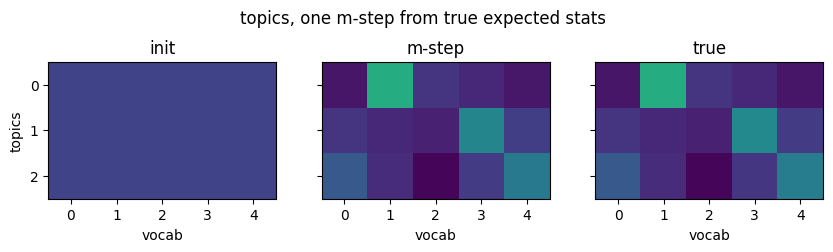

In [20]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(10,2))

for ax, (name, mat) in zip(axs, [("init", init_topics), ("m-step", new_topics), ("true", true_topics)]):
    ax.imshow(mat, vmin=0, vmax=1, interpolation='none')
    ax.set_title(name)
    ax.set_xlabel('vocab')

axs[0].set_yticks(range(n_topics))
axs[0].set_ylabel('topics')

fig.suptitle("topics, one m-step from true expected stats", y=1.1);

**Validate M-step for weights**

In [ ]:
true_topics, true_weights, true_scales, true_scounts = true_params

init_weights = jnp.ones((n_docs, n_topics)) / n_topics
prior_params = (1.001, 1e-4)

new_weights = m_step_weights(
    expected_zs,
    (true_topics, init_weights, true_scales, true_scounts),
    prior_params,
    max_stepsize=1,
    a_min=1e-4
)

frac_dev, dev_range = xent_frac_dev(new_weights, true_weights, init_weights)

with jnp.printoptions(precision=3):
    print(f"{frac_dev.mean()=}")
    print(f"{jnp.all(frac_dev[dev_range >= 1e-3] >= 0.70)=}")

frac_dev.mean()=Array(0.997, dtype=float32)
True


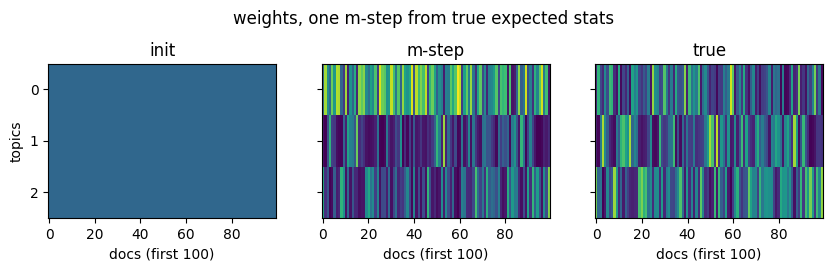

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(10,2))

for ax, (name, mat) in zip(axs, [("init", init_weights), ("m-step", new_weights), ("true", true_weights)]):
    ax.imshow(mat[:100].T, vmin=0, vmax=1, interpolation='none', aspect='auto')
    ax.set_title(name)
    ax.set_xlabel('docs (first 100)')

axs[0].set_yticks(range(n_topics))
axs[0].set_ylabel('topics')
fig.suptitle("weights, one m-step from true expected stats", y=1.15);

**Validate M-step for scales**

In [ ]:
true_topics, true_weights, true_scales, true_scounts = true_params

init_scales = jnp.ones(vocab_size) / vocab_size
prior_params = (1.001, 1e-4)

new_scales = m_step_scales(
    expected_zs,
    (true_topics, true_weights, init_scales, true_scounts),
    prior_params,
    max_stepsize=1,
    a_min=1e-4
)

frac_dev, dev_range = xent_frac_dev(new_scales, true_scales, init_scales)

with jnp.printoptions(precision=3):
    print(f"{frac_dev=}")
    print(f"{jnp.all(frac_dev[dev_range >= 1e-3] >= 0.70)=}")

frac_dev=Array(1., dtype=float32)
jnp.all(frac_dev[dev_range >= 1e-3] >= 0.70)=Array(True, dtype=bool)


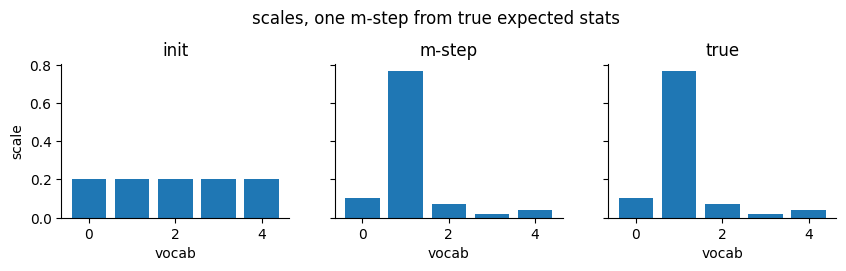

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(10,2))

for ax, (name, vec) in zip(axs, [("init", init_scales), ("m-step", new_scales), ("true", true_scales)]):
    ax.bar(range(vocab_size), vec)
    ax.set_title(name)
    ax.set_xlabel('vocab')

axs[0].set_ylabel('scale')
sns.despine()

fig.suptitle("scales, one m-step from true expected stats", y=1.15);

**Validate M-step for scounts**

Since this parameter consists of count data, we simply evaluate the standardized absolute accuracy,
$$
\textrm{acc}(y_m) = 1 - \frac{x_m - y_m}{x_m}
$$
where $x_m$ is the true count and $y_m$ is the inferred count.

In [ ]:
true_topics, true_weights, true_scales, true_scounts = true_params

init_scounts = data.sum(axis=-1) * vocab_size
prior_params = (1.001, 1e-4)

new_scounts = m_step_scounts(
    expected_zs,
    (true_topics, true_weights, true_scales, init_scounts),
    prior_params,
    max_stepsize=1,
    a_min=1e-4
)

acc = 1 - jnp.abs(true_scounts - new_scounts) / true_scounts

with jnp.printoptions(precision=3):
    print(f"{acc.mean=}")
    print(f"{jnp.all(acc >= 0.90)=}")

acc.mean=<bound method mean of Array([1.   , 0.999, 1.   , ..., 1.   , 1.   , 1.   ], dtype=float32)>
jnp.all(acc >= 0.90)=Array(True, dtype=bool)


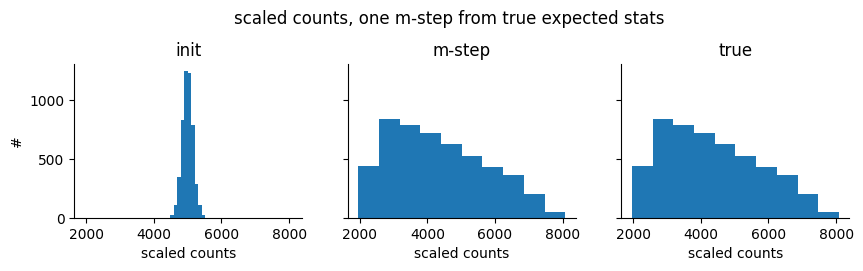

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(10,2))

for ax, (name, vec) in zip(axs, [("init", init_scounts), ("m-step", new_scounts), ("true", true_scounts)]):
    ax.hist(vec)
    ax.set_title(name)
    ax.set_xlabel('scaled counts')

axs[0].set_ylabel('#')
sns.despine()

fig.suptitle("scaled counts, one m-step from true expected stats", y=1.15);

## Fit from scratch

In [17]:
def em(
    data: Array,
    init_params: Params,
    prior_params: PriorParams,
    max_em_steps: int=10,
    max_stepsize: dict | float=1e-3,
    freeze_params: Sequence=()
):

    # Standardize max_stepsize to be dict
    if isinstance(max_stepsize, (int, float)):
            max_stepsize = {param_: max_stepsize for param_ in ('topics', 'weights', 'scales')}
    assert isinstance(max_stepsize, dict)

    def multinomial_ll(topics, weights, scales):
        probs = scales * (weights @ topics)
        probs /= probs.sum(axis=-1, keepdims=True)

        return tfd.Multinomial(data.sum(axis=-1), probs=probs).log_prob(data).mean()

    topics, weights, scales, scounts = init_params

    params_by_iter = []
    nlls_by_iter = []
    for _ in tqdm(range(max_em_steps)):
        nlls = []

        if 'topics' not in freeze_params:
            expected_zs = e_step(data, topics, weights, scales)

            topics = m_step_topics(
                expected_zs,
                (topics, weights, scales, scounts),
                (prior_params.topic_conc, prior_params.topic_rate),
                max_stepsize=max_stepsize['topics']
            )

        nlls.append(multinomial_ll(topics, weights, scales))
        
        if 'weights' not in freeze_params:
            expected_zs = e_step(data, topics, weights, scales)

            weights = m_step_weights(
                expected_zs,
                (topics, weights, scales, scounts),
                (prior_params.weight_conc, prior_params.weight_rate),
                max_stepsize=max_stepsize['weights']
            )

        nlls.append(multinomial_ll(topics, weights, scales))
        
        if 'scales' not in freeze_params:
            expected_zs = e_step(data, topics, weights, scales)

            scales = m_step_scales(
                expected_zs,
                (topics, weights, scales, scounts),
                (prior_params.scale_conc, prior_params.scale_rate),
                max_stepsize=max_stepsize['scales']
            )

        nlls.append(multinomial_ll(topics, weights, scales))

        # Always update scounts
        expected_zs = e_step(data, topics, weights, scales)

        scounts = m_step_scounts(
            expected_zs,
            (topics, weights, scales, scounts),
            (prior_params.scount_conc, prior_params.scount_rate),
        )

        params_by_iter.append(Params(topics, weights, scales, scounts))
        nlls_by_iter.append(nlls)
    
    nlls_by_iter = jnp.array(nlls_by_iter) # shape (max_em_steps, 3)

    return params_by_iter, nlls_by_iter

### Sanity check: Initialize parameters with true parameters

In this setting, since the true parameters should be the "optimal" parameters,
we expect that the returned parameters are identical to the true parameters.

In [ ]:
# Sanity check: Given all true parameters as initial parameters, algoithm should effectively be no-op
prior_params = PriorParams()
params_by_iter, nlls_by_iter = em(data, true_params, prior_params, max_em_steps=5, max_stepsize=1)

100%|██████████| 5/5 [00:14<00:00,  2.94s/it]


Qualitatively, we find that the parameters all remain the same as the true parameters, as expected.

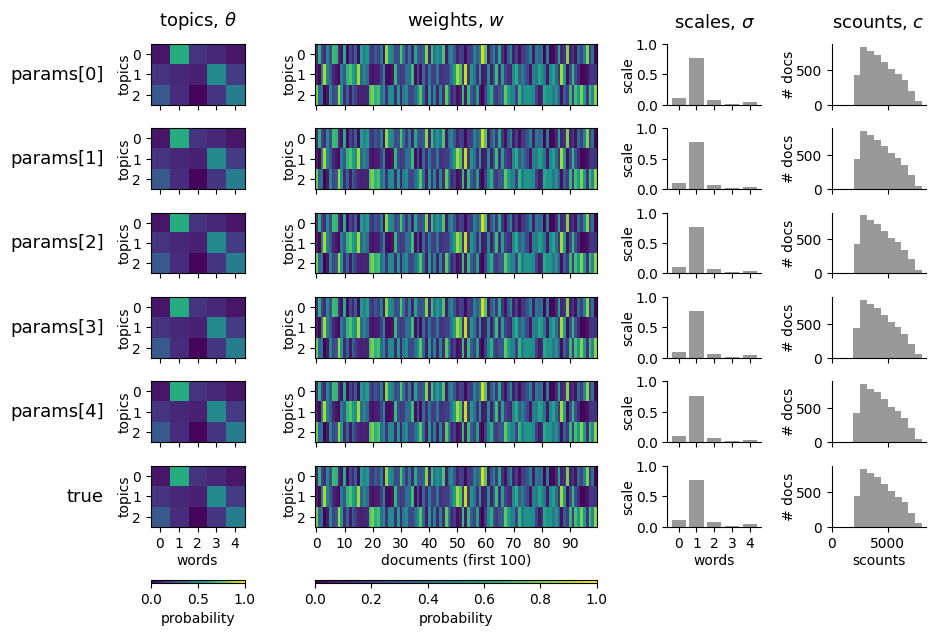

In [ ]:
compare_params({
    **{f"params[{i}]": params_ for i, params_ in enumerate(params_by_iter)},
    "true": true_params,
});

Numerically, however, we see a very slight increase in elementwise absolute error.

Overall, however, I'd say that that this error is acceptable.

5


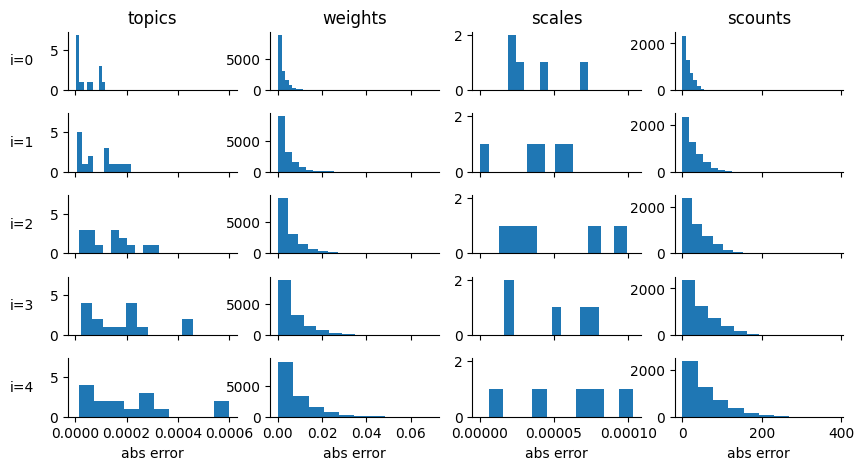

In [ ]:
n_iters = len(params_by_iter)
print(n_iters)
fig, axs = plt.subplots(
    nrows=n_iters, ncols=4, figsize=(10, 1*n_iters),
    gridspec_kw={'hspace': 0.4},
    sharex='col', sharey='col',
)

for i in range(n_iters):
    for ax, a, b in zip(axs[i], true_params, params_by_iter[i]):
        err = jnp.abs(a-b).ravel()
        ax.hist(err)

# Label columns
for ax, name in zip(axs[0], ('topics', 'weights', 'scales', 'scounts')):
    ax.set_title(name)

# Label rows
for i, ax in enumerate(axs[:,0]):
    ax.text(-0.2, 0.5, f"{i=}", ha='right', va='center', transform=ax.transAxes)

# Label x_axes
for ax in axs[-1]:
    ax.set_xlabel('abs error')

sns.despine()

### Learning from scratch

We initialize our parameters as follows:
\begin{align*}
\theta_k^{(0)} &\leftarrow \textrm{Dir}\left(\textstyle{\frac{1}{V}}\right) \\
w_m^{(0)} &\leftarrow \textrm{Dir}\left(\textstyle{\frac{1}{K}}\right) \\
\sigma_v^{(0)} &\leftarrow \frac{\textrm{med}(X_{:,v})}{\sum_v\textrm{med}(X_{:,v})} \\
c_m^{(0)} &\leftarrow n_m V
\end{align*}
where $X$ is the observed data.

In [50]:
n_inits = 5

init_true = ()  # params to initialize to true

init_params = []
for i in range(n_inits):
    s1, s2 = jr.split(jr.fold_in(jr.key(10), i))
    init_params.append(Params(
        topics=jr.dirichlet(s1, 2.001*jnp.ones(vocab_size), (n_topics,)) if 'topics' not in init_true else true_params.topics,
        weights=jr.dirichlet(s2, 1.001*jnp.ones(n_topics), (n_docs,)) if 'weights' not in init_true else true_params.weights,
        scales=jnp.median(data, axis=0)/jnp.median(data, axis=0).sum() if 'scales' not in init_true else true_params.scales,
        scounts=data.sum(axis=-1) * vocab_size if 'scounts' not in init_true else true_params.scounts,
    ))

In [55]:
# 60-90s for K=3
# should really increase this to 50 steps

max_stepsize = 1
max_em_steps = 10
prior_params = PriorParams()

params_by_iter, nlls_by_iter = [], []
for init_params_ in init_params:
    params_by_iter_, nlls_by_iter_ = em(
        data, init_params_, prior_params,
        max_em_steps=max_em_steps, max_stepsize=max_stepsize,
        freeze_params=(),
    )

    params_by_iter.append(params_by_iter_)
    nlls_by_iter.append(nlls_by_iter_)

100%|██████████| 10/10 [01:34<00:00,  9.42s/it]


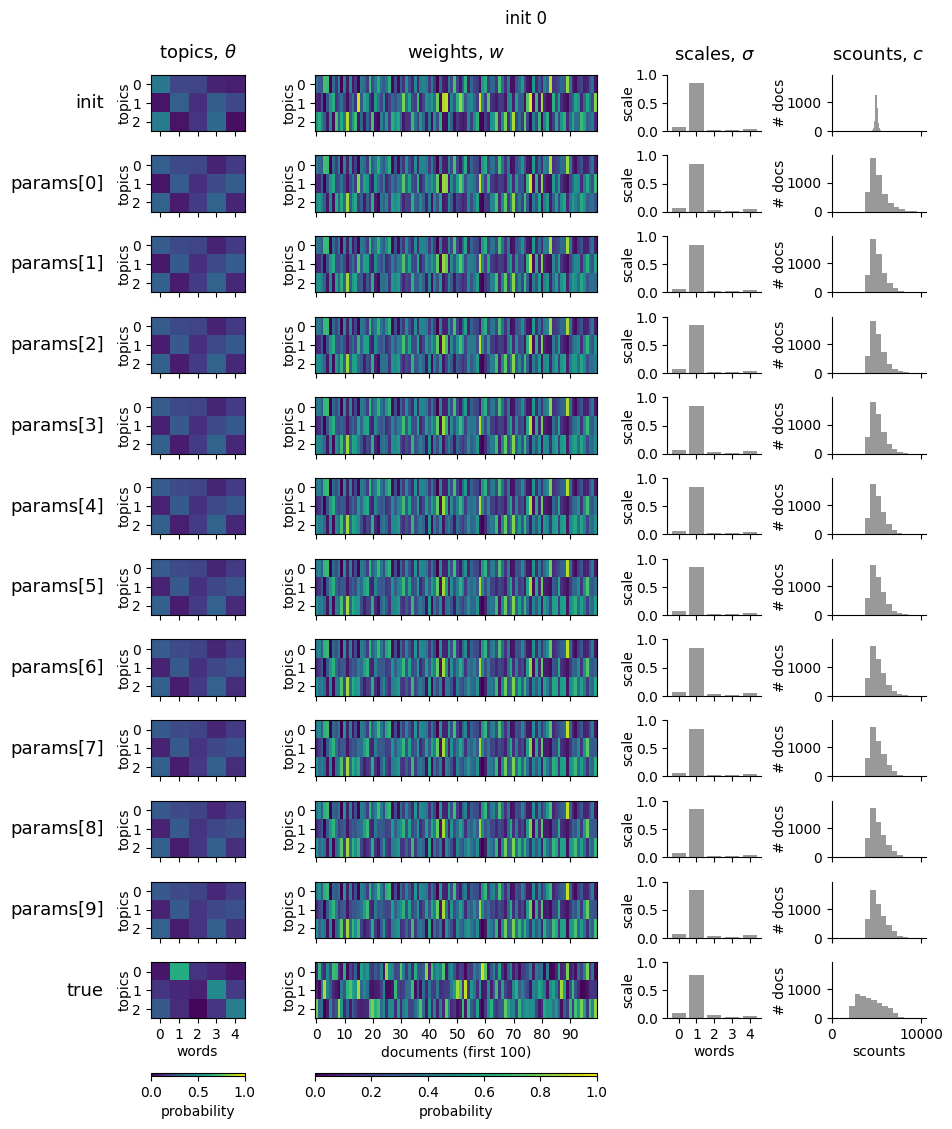

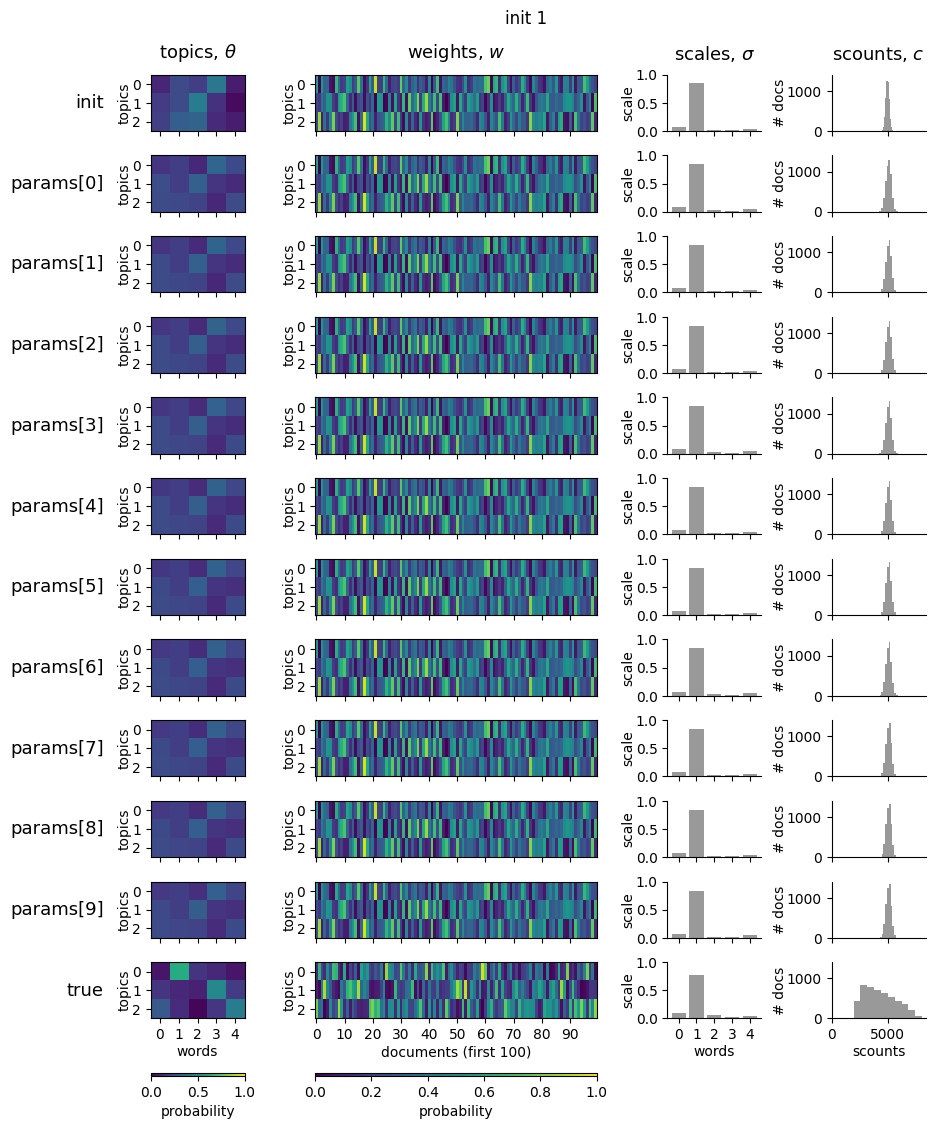

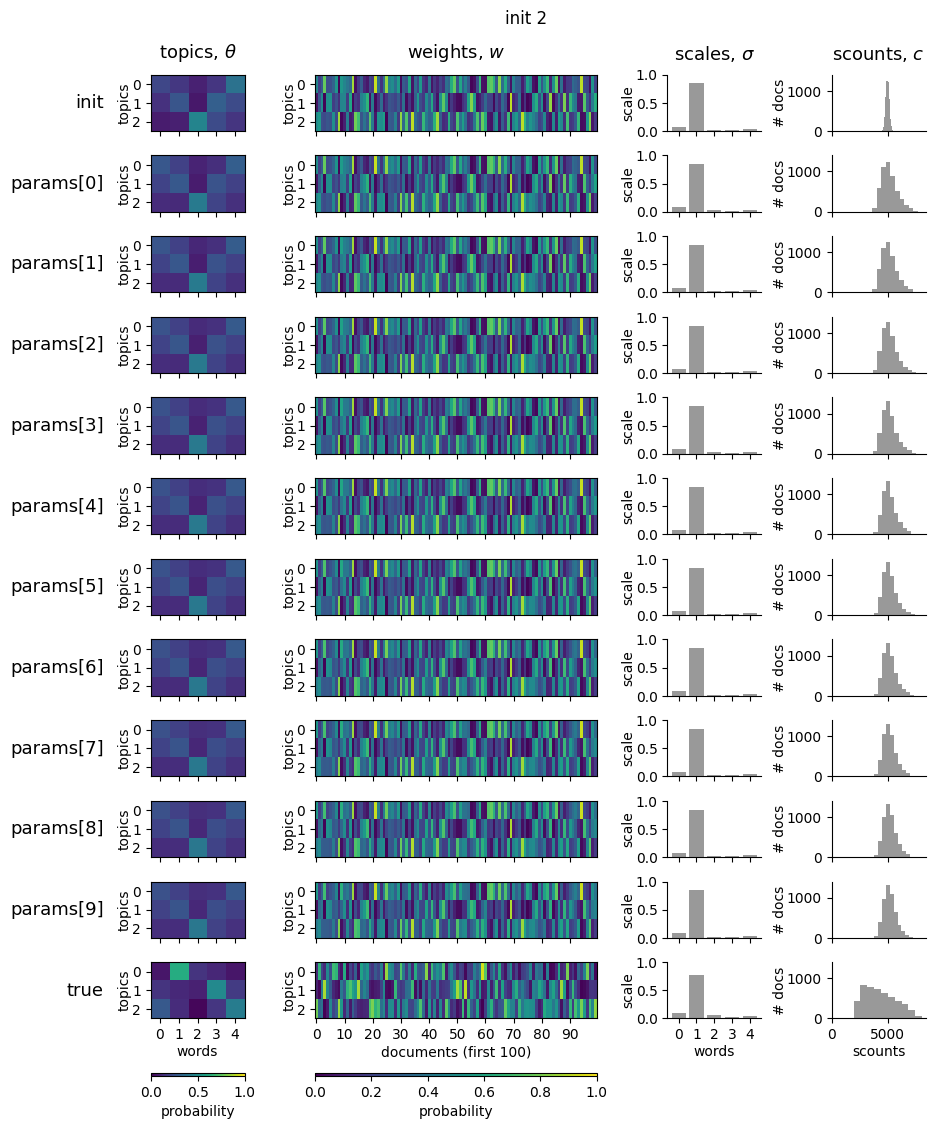

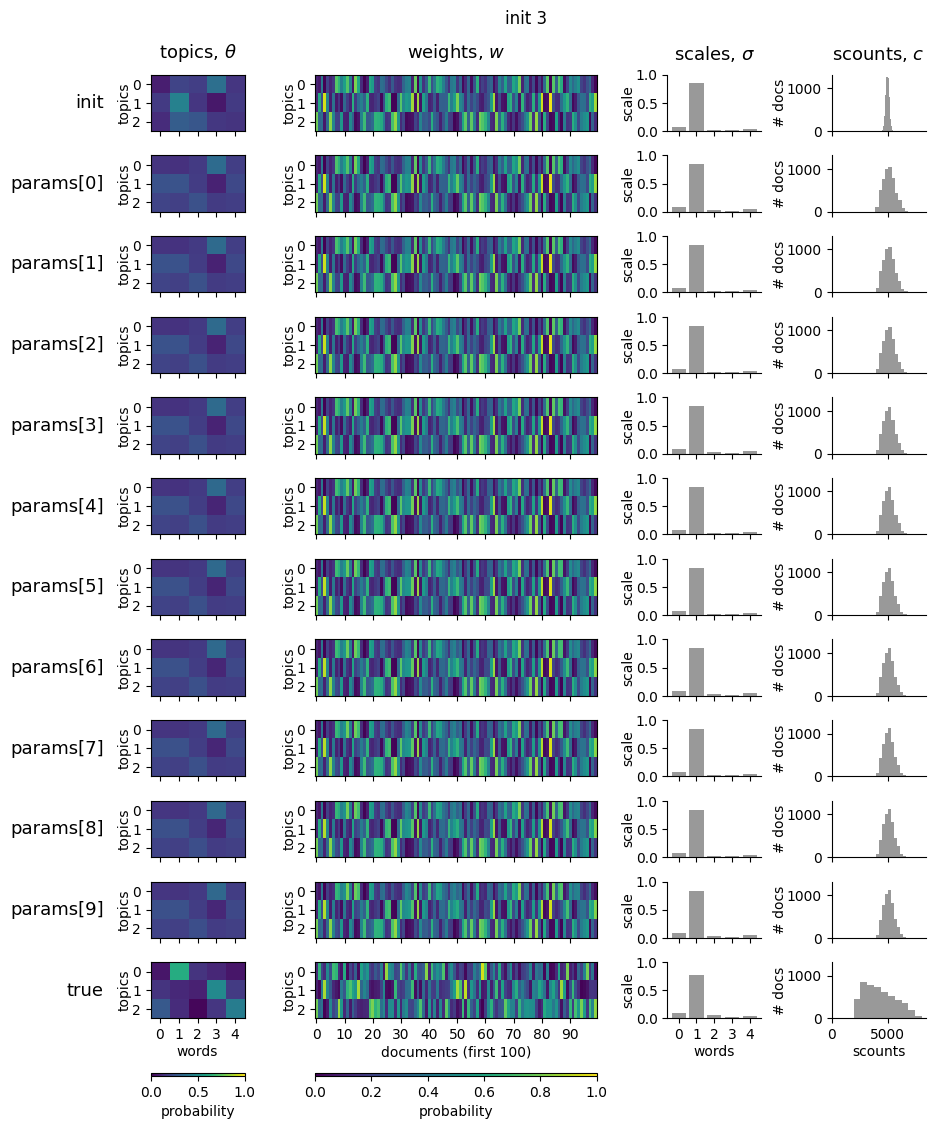

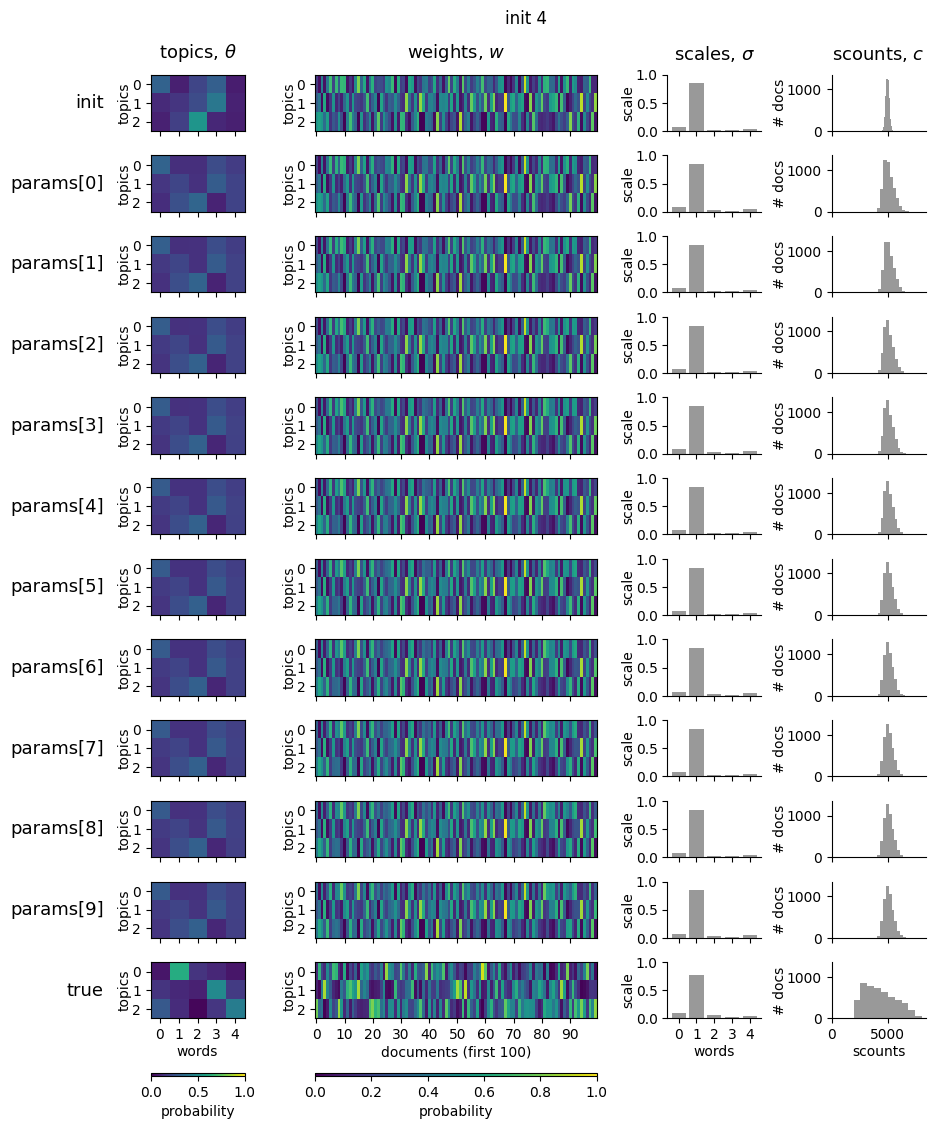

In [61]:
for i, (init_params_, params_by_iter_) in enumerate(zip(init_params, params_by_iter)):
    fig = compare_params({
        'init': init_params_,
        **{f"params[{i}]": params_ for i, params_ in enumerate(params_by_iter_)},
        "true": true_params,
    })
    fig.suptitle(f"init {i}", y=0.93)

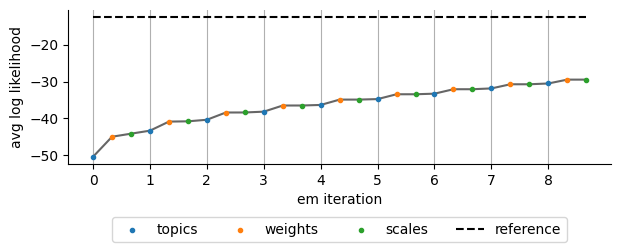

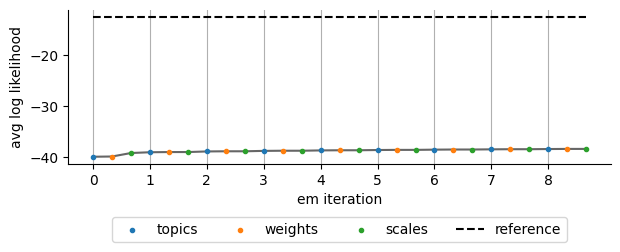

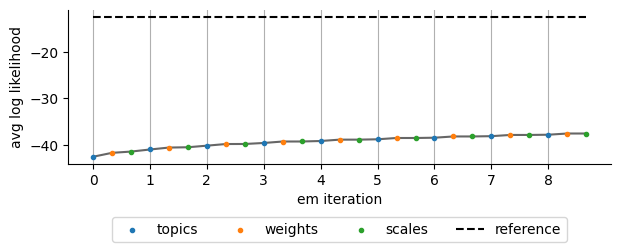

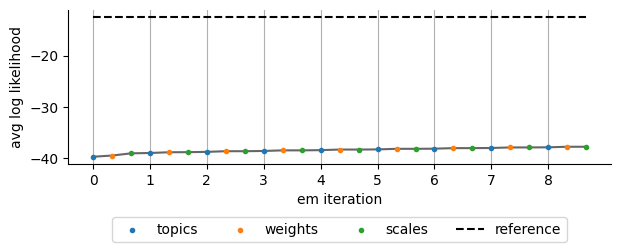

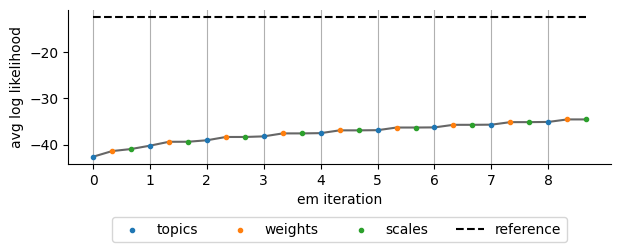

In [77]:
for i, nlls_by_iter_ in enumerate(nlls_by_iter):

    plt.figure(figsize=(7,2))

    x_offset = 0
    endpt = len(nlls_by_iter_) - x_offset - 1
    nlls = nlls_by_iter_[x_offset:endpt]
    n_em_steps, n_params = nlls.shape
    xs = jnp.arange(n_em_steps*n_params).reshape(n_em_steps, n_params)

    plt.plot(xs.ravel(), nlls.ravel(), color='0.4')
    for xs_, nll, label in zip(xs.T, nlls.T, ('topics', 'weights', 'scales')):
        plt.scatter(xs_, nll, label=label, marker='.', zorder=3)

    if n_em_steps <= 10:
        xticks = jnp.arange(n_em_steps)
    elif n_em_steps <= 50:
        xticks = jnp.arange(0, n_em_steps, 5)
    else:
        xticks = jnp.arange(0, n_em_steps, 10)

    plt.xticks(xticks*n_params, xticks+x_offset);
    plt.grid(axis='x')

    true_probs = true_params.scales * (true_params.weights @ true_params.topics)
    true_probs /= true_probs.sum(axis=-1, keepdims=True)
    ref_nll = tfd.Multinomial(data.sum(axis=-1), probs=true_probs).log_prob(data)

    ref_nll_vec = jnp.ones(n_em_steps*n_params) * ref_nll.mean()
    plt.plot(xs.ravel(), ref_nll_vec, label='reference', color='k', ls='--')

    plt.xlabel('em iteration')
    plt.ylabel('avg log likelihood')
    plt.legend(bbox_to_anchor=(0.5,-0.3), loc='upper center', ncols=n_params + 1)
    sns.despine()

**Give model more parameters**

Now, what if we give the model more parameters to work with, i.e. increase the number of topics?

In [33]:
n_inits = 5
n_topics = 5

init_true = ()  # params to initialize to true

init_params = []
for i in range(n_inits):
    s1, s2 = jr.split(jr.fold_in(jr.key(10), i))
    init_params.append(Params(
        topics=jr.dirichlet(s1, 1.001*jnp.ones(vocab_size), (n_topics,)) if 'topics' not in init_true else true_params.topics,
        weights=jr.dirichlet(s2, 1.001*jnp.ones(n_topics), (n_docs,)) if 'weights' not in init_true else true_params.weights,
        scales=jnp.median(data, axis=0)/jnp.median(data, axis=0).sum() if 'scales' not in init_true else true_params.scales,
        scounts=data.sum(axis=-1) * vocab_size if 'scounts' not in init_true else true_params.scounts,
    ))

In [19]:
# 2-3 minutes for K=5, n_iter = 20
# should really increase this to 50 steps

max_stepsize = 1
max_em_steps = 50
prior_params = PriorParams()

params_by_iter, nlls_by_iter = [], []
for _init_params in init_params:
    _params_by_iter, _nlls_by_iter = em(
        data, _init_params, prior_params,
        max_em_steps=max_em_steps, max_stepsize=max_stepsize,
        freeze_params=(),
    )

    params_by_iter.append(_params_by_iter)
    nlls_by_iter.append(_nlls_by_iter)

100%|██████████| 50/50 [03:48<00:00,  4.58s/it]


In [30]:
# # Cell to run for an additional N steps
# # Adds to params_by_iter,    nlls_by_iter

# max_em_steps = 20

# for i_init, params_ in enumerate(params_by_iter):
#     params_by_iter_, nlls_by_iter_ = em(
#         data, params_[-1], prior_params,
#         max_em_steps=max_em_steps, max_stepsize=max_stepsize,
#         freeze_params=(),
#     )

#     params_by_iter[i_init].extend(params_by_iter_)
#     nlls_by_iter[i_init] = jnp.concatenate([nlls_by_iter[i_init], nlls_by_iter_])

100%|██████████| 20/20 [01:20<00:00,  4.02s/it]


In [ ]:
# # Save parameters
# with open("3-topic-5-inits-50-steps.pkl", "wb") as f:
#     pickle.dump(
#         dict(
#             true_params=true_params,
#             init_params=init_params,
#             params_by_iter=params_by_iter,
#             nlls_by_iter=nlls_by_iter,
#             prior_params=prior_params,
#             max_stepsize=max_stepsize,
#         ),
#         f,
#     )

**Visualize results**

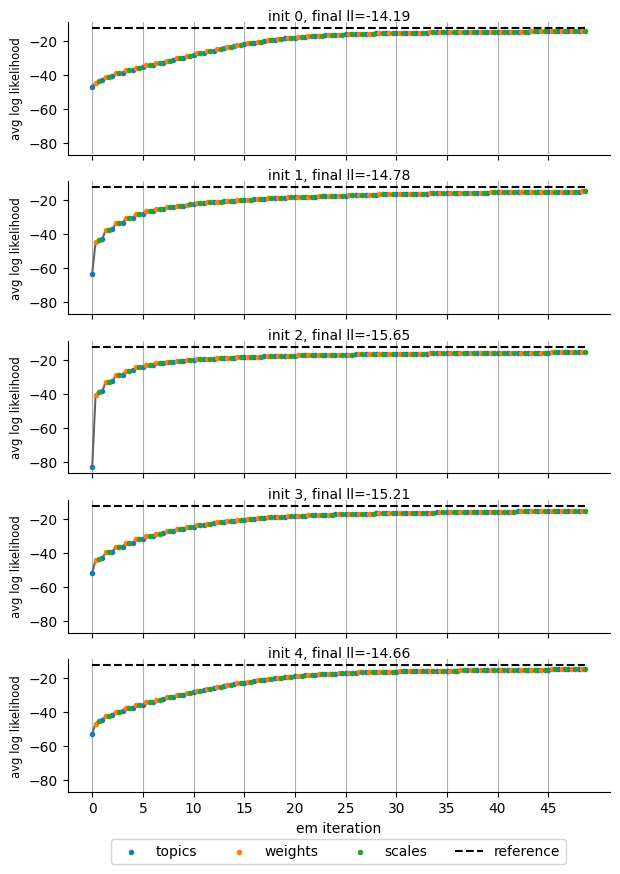

In [58]:
n_inits = len(nlls_by_iter)

fig, axs = plt.subplots(
    nrows=n_inits, sharex=True, sharey=True, figsize=(7, 2*n_inits),
    gridspec_kw={'hspace': 0.2}
)

for i, _nlls_by_iter in enumerate(nlls_by_iter):
    ax = axs[i]

    x_offset = 0
    endpt = len(_nlls_by_iter) - x_offset - 1
    nlls = _nlls_by_iter[x_offset:endpt]
    n_em_steps, n_params = nlls.shape
    xs = jnp.arange(n_em_steps*n_params).reshape(n_em_steps, n_params)

    ax.plot(xs.ravel(), nlls.ravel(), color='0.4')
    for xs_, nll, label in zip(xs.T, nlls.T, ('topics', 'weights', 'scales')):
        ax.scatter(xs_, nll, label=label, marker='.', zorder=3)

    if n_em_steps <= 10:
        xticks = jnp.arange(n_em_steps)
    elif n_em_steps <= 50:
        xticks = jnp.arange(0, n_em_steps, 5)
    else:
        xticks = jnp.arange(0, n_em_steps, 10)

    ax.set_xticks(xticks*n_params, xticks+x_offset);
    ax.grid(axis='x')

    true_probs = true_params.scales * (true_params.weights @ true_params.topics)
    true_probs /= true_probs.sum(axis=-1, keepdims=True)
    ref_nll = tfd.Multinomial(data.sum(axis=-1), probs=true_probs).log_prob(data)

    ref_nll_vec = jnp.ones(n_em_steps*n_params) * ref_nll.mean()
    ax.plot(xs.ravel(), ref_nll_vec, label='reference', color='k', ls='--')

    ax.set_ylabel(f'avg log likelihood', fontsize='small')
    ax.set_title(f"init {i}, final ll={nlls[-1,-1]:.2f}", y=0.95, fontsize='medium')

ax.set_xlabel('em iteration')

ax.legend(bbox_to_anchor=(0.5,-0.3), loc='upper center', ncols=n_params + 1)

sns.despine()

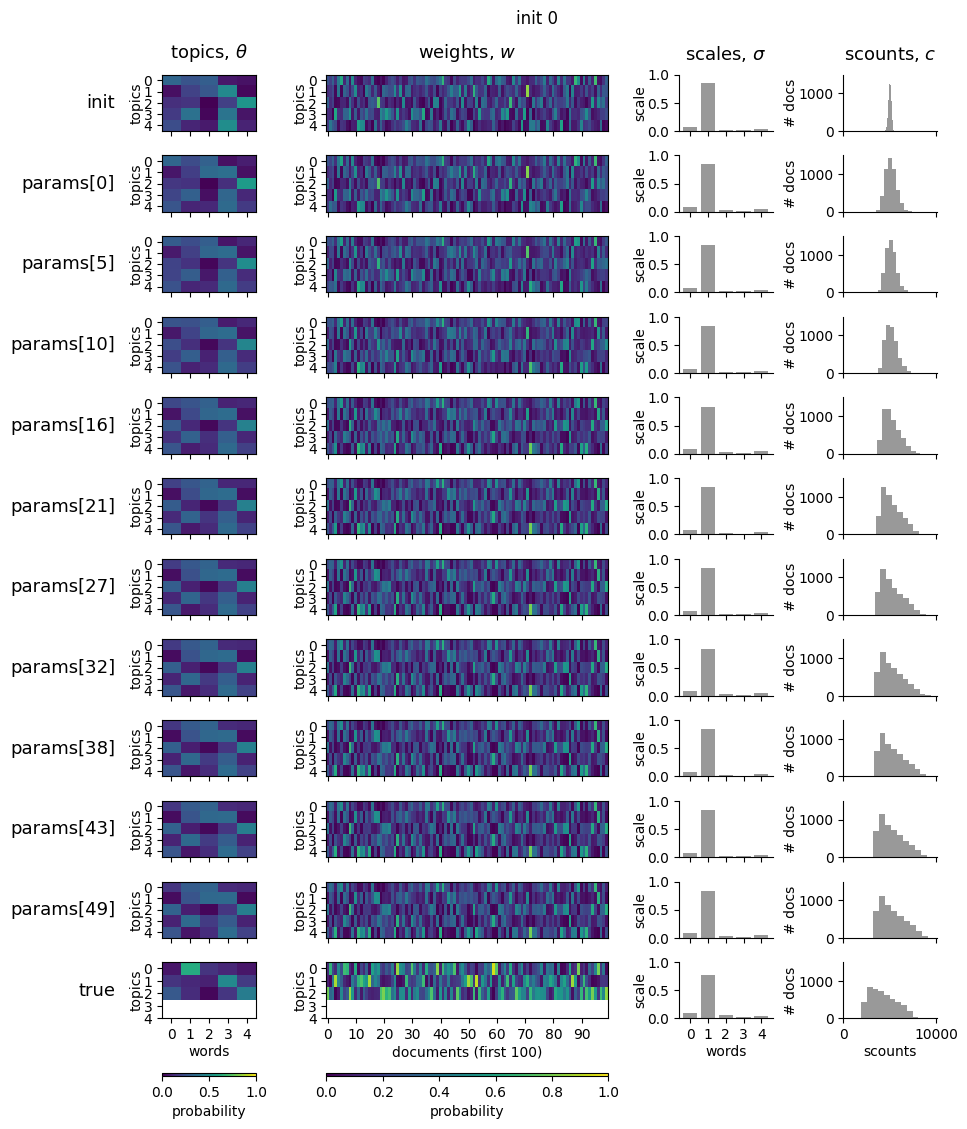

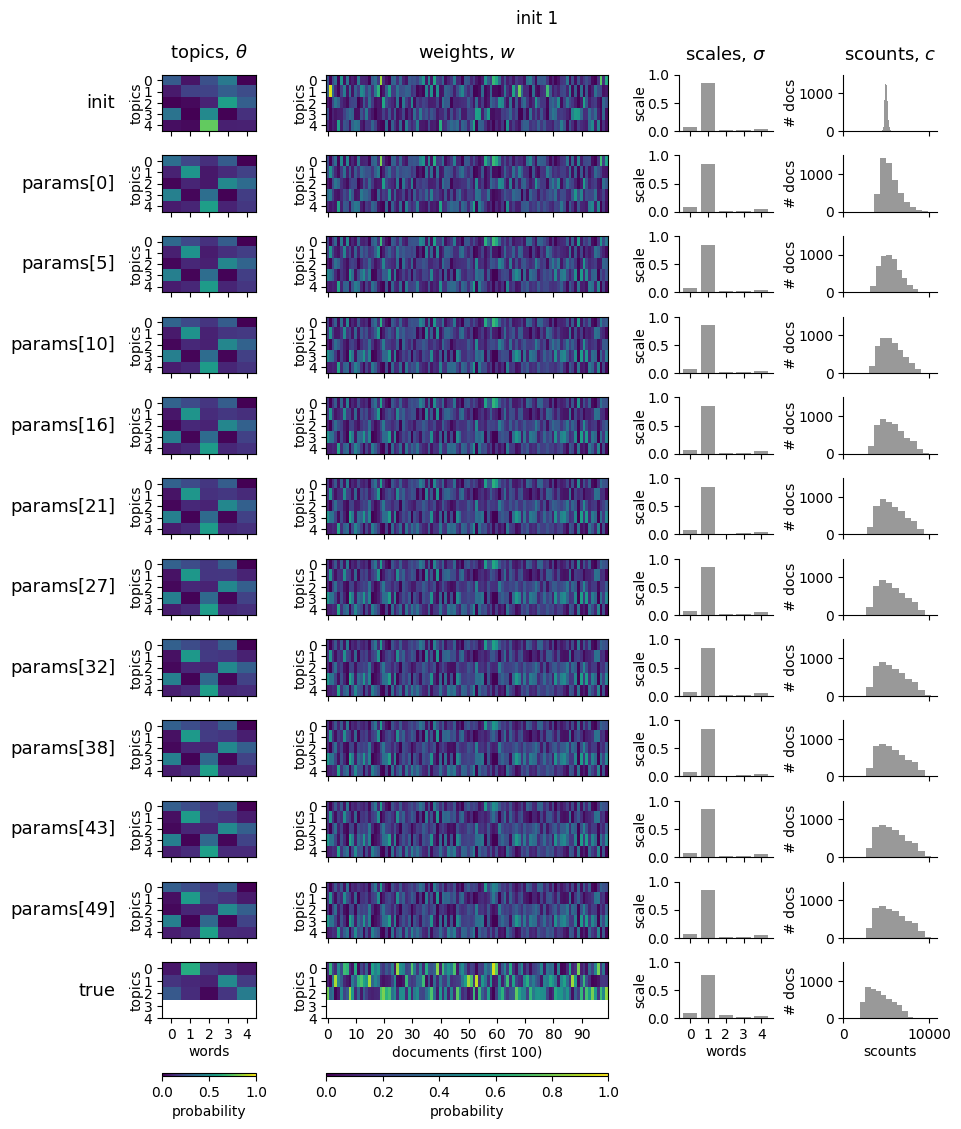

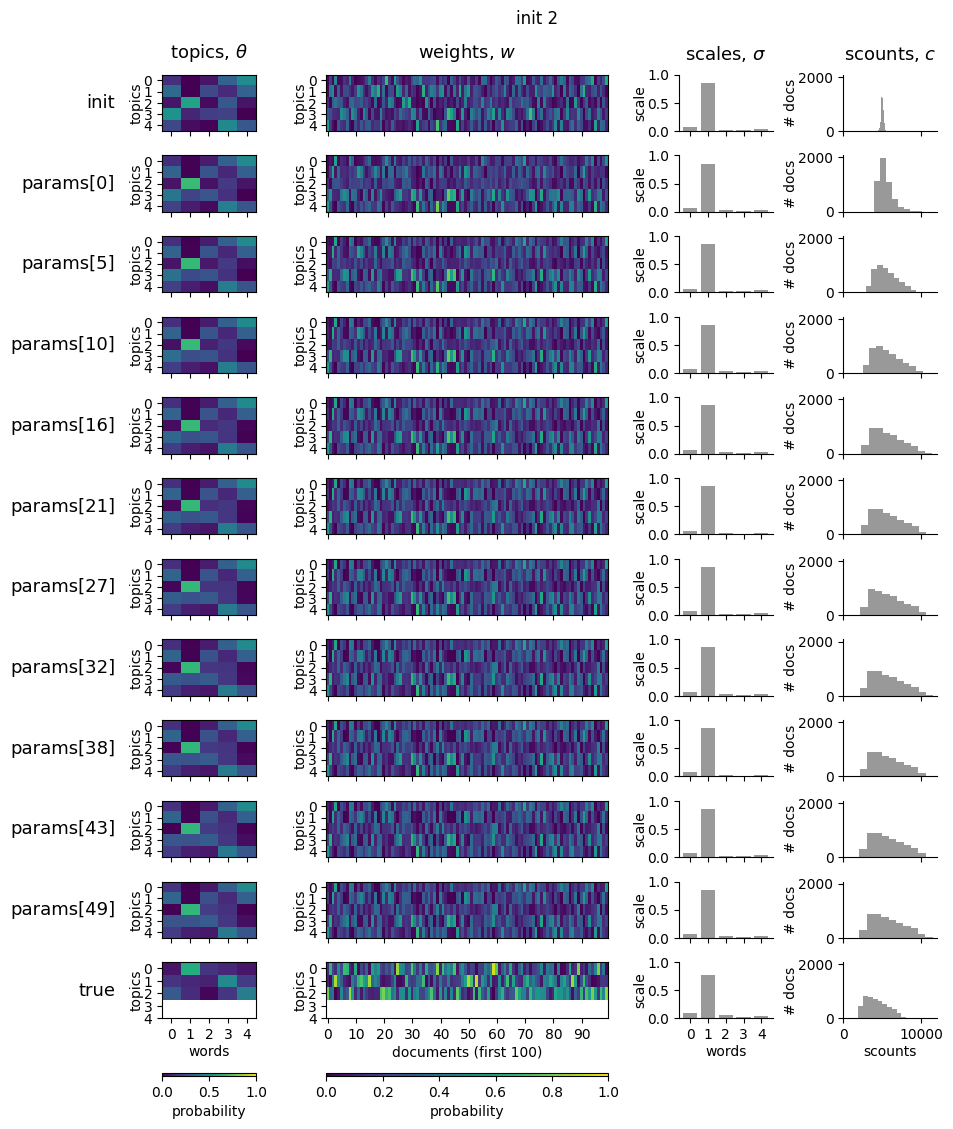

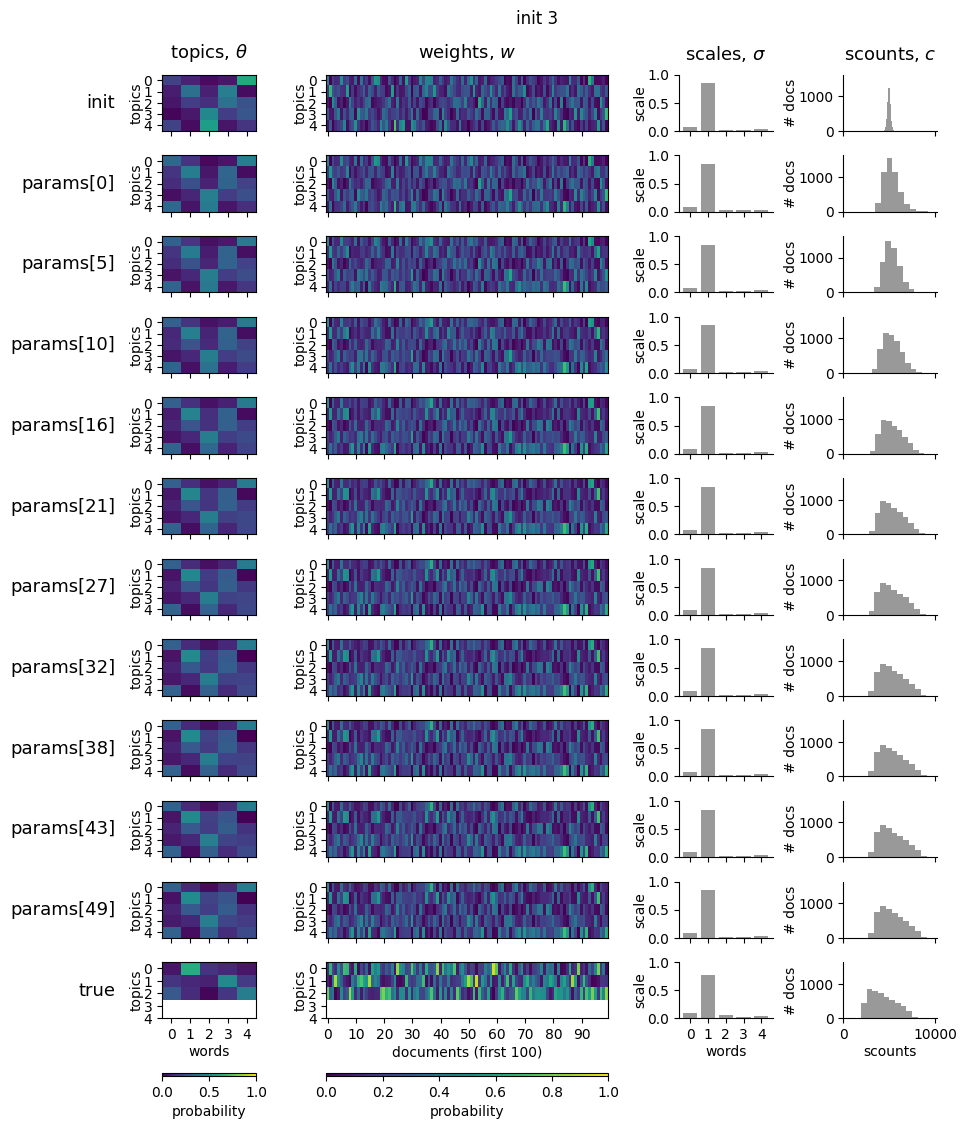

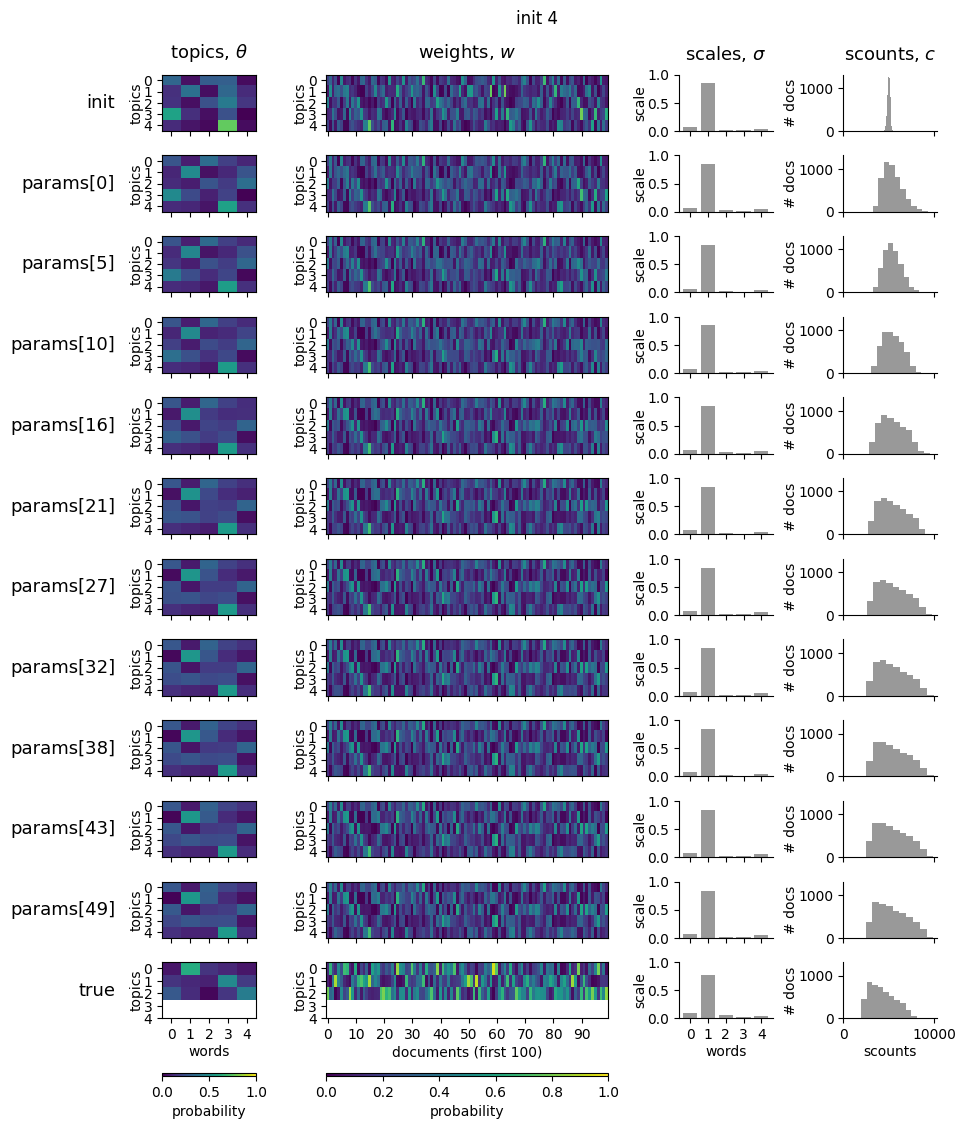

In [26]:
for i, (init_params_, params_by_iter_) in enumerate(zip(init_params, params_by_iter)):
    fig = compare_params({
        'init': init_params_,
        **{f"params[{i}]": params_by_iter_[i] for i in jnp.linspace(0, len(params_by_iter_)-1, num=10, dtype=int)},
        "true": true_params,
    })
    fig.suptitle(f"init {i}", y=0.93)

**Permute and make metrics**

In [18]:
import pickle

with open("3-topic-5-inits-50-steps.pkl", "rb") as f:
    tmp = pickle.load(f)
    true_params = tmp['true_params']
    init_params = tmp['init_params']
    params_by_iter = tmp['params_by_iter']
    nlls_by_iter = tmp['nlls_by_iter']
    prior_params = tmp['prior_params']
    max_stepsize = tmp['max_stepsize']


Since we have the true topics, we first verify whether the solution is contained within the params. Topics look pretty good!!

In [19]:
# Permute topics for best fit

import numpy as onp
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist

nxent = lambda p, q: (-p * onp.log(q)).sum()

permd_params = []
perms = []
for _params_by_iter in params_by_iter:
    # Just find permutation for last iteration
    topics, weights, scales, scounts = _params_by_iter[-1]

    # cost_matrix: shape (n_true_topics, n_fitted_topics)
    cost_matrix = cdist(true_params.topics, topics, nxent) 
    _, i_perm = linear_sum_assignment(cost_matrix)

    permd_topics =topics[i_perm,]
    permd_weights = weights[:,i_perm]
    permd_weights /= permd_weights.sum(axis=-1, keepdims=True)
    
    perms.append(i_perm)
    permd_params.append(Params(permd_topics, permd_weights, scales, scounts))

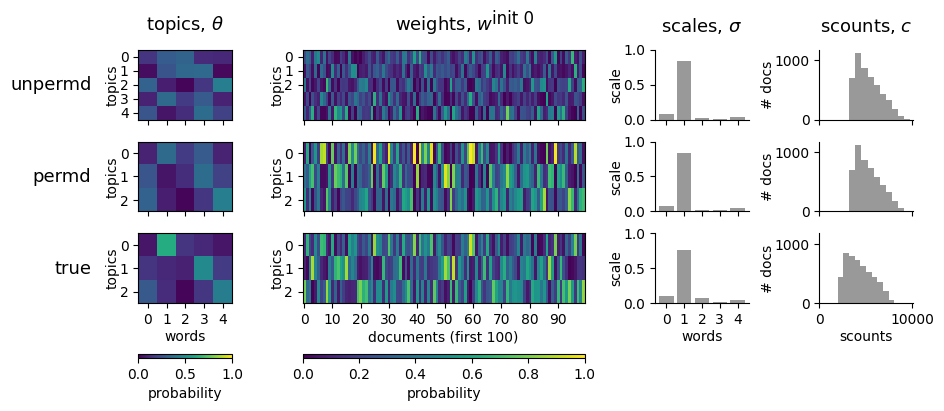

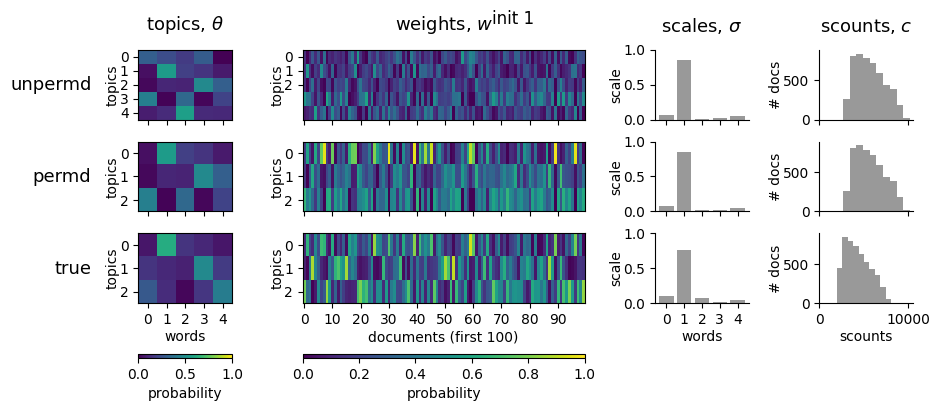

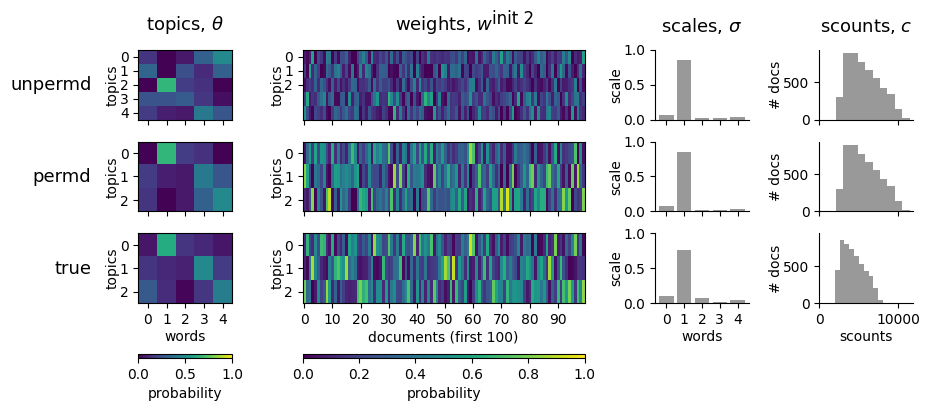

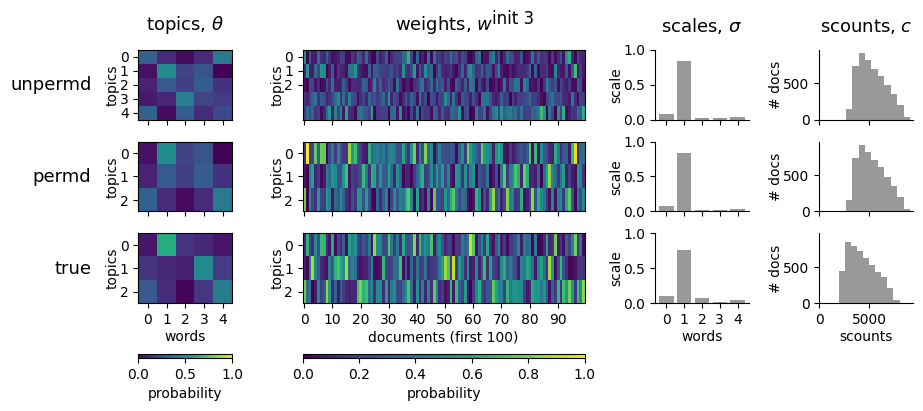

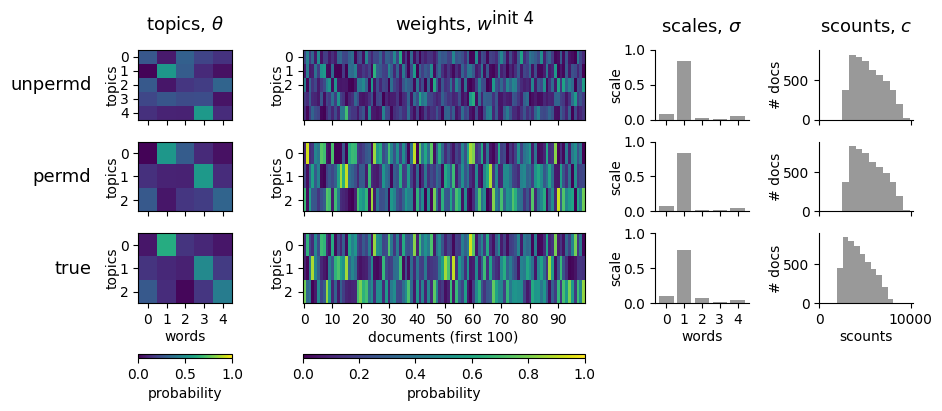

In [23]:
for i_init, (unpermd_by_iter, permd) in enumerate(zip(params_by_iter, permd_params)):
    fig = compare_params({
        f'unpermd[{len(unpermd_by_iter)}]': unpermd_by_iter[-1],
        'permd': permd,
        'true': true_params
    })
    fig.suptitle(f'init {i_init}')

So, let's try refitting from here...Fingers crossed!

In [20]:
max_stepsize = 1
max_em_steps = 50
prior_params = PriorParams()

refit_params_by_iter, refit_nlls_by_iter = [], []

for init_params in permd_params:
    _params_by_iter, _nlls_by_iter = em(
        data, init_params, prior_params,
        max_em_steps=max_em_steps, max_stepsize=max_stepsize,
        freeze_params=(),
    )

    refit_params_by_iter.append(_params_by_iter)
    refit_nlls_by_iter.append(_nlls_by_iter)

100%|██████████| 50/50 [03:03<00:00,  3.67s/it]


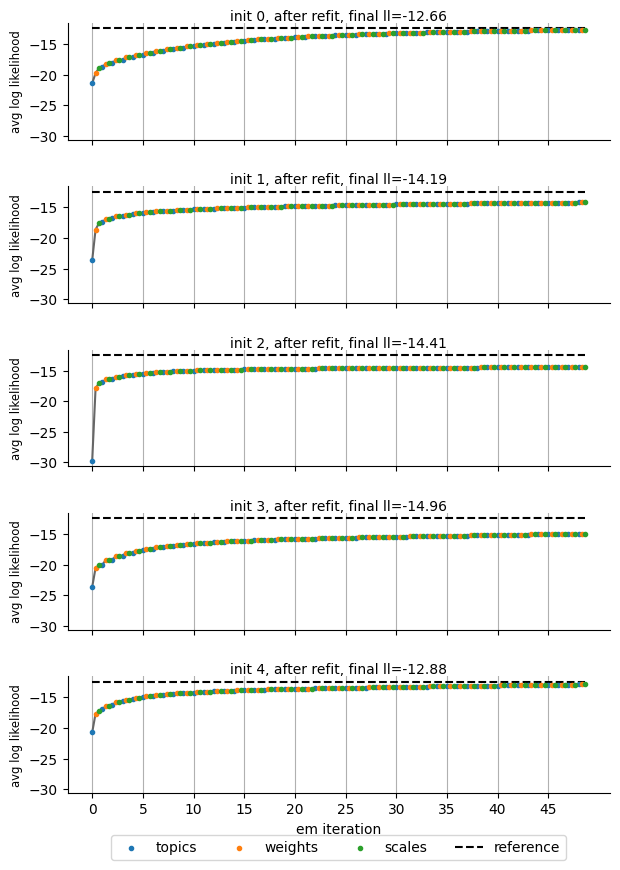

In [57]:
n_inits = len(refit_nlls_by_iter)

fig, axs = plt.subplots(nrows=n_inits, sharex=True, sharey=True, figsize=(7, 2*n_inits), gridspec_kw={'hspace': 0.4})

for i, _nlls_by_iter in enumerate(refit_nlls_by_iter):
    ax = axs[i]

    x_offset = 0
    endpt = len(_nlls_by_iter) - x_offset - 1
    nlls = _nlls_by_iter[x_offset:endpt]
    n_em_steps, n_params = nlls.shape
    xs = jnp.arange(n_em_steps*n_params).reshape(n_em_steps, n_params)

    ax.plot(xs.ravel(), nlls.ravel(), color='0.4')
    for xs_, nll, label in zip(xs.T, nlls.T, ('topics', 'weights', 'scales')):
        ax.scatter(xs_, nll, label=label, marker='.', zorder=3)

    if n_em_steps <= 10:
        xticks = jnp.arange(n_em_steps)
    elif n_em_steps <= 50:
        xticks = jnp.arange(0, n_em_steps, 5)
    else:
        xticks = jnp.arange(0, n_em_steps, 10)

    ax.set_xticks(xticks*n_params, xticks+x_offset);
    ax.grid(axis='x')

    true_probs = true_params.scales * (true_params.weights @ true_params.topics)
    true_probs /= true_probs.sum(axis=-1, keepdims=True)
    ref_nll = tfd.Multinomial(data.sum(axis=-1), probs=true_probs).log_prob(data)

    ref_nll_vec = jnp.ones(n_em_steps*n_params) * ref_nll.mean()
    ax.plot(xs.ravel(), ref_nll_vec, label='reference', color='k', ls='--')

    ax.set_ylabel('avg log likelihood', fontsize='small')
    ax.set_title(f"init {i}, after refit, final ll={nlls[-1,-1]:.2f}", y=0.95, fontsize='medium')

ax.set_xlabel('em iteration')
ax.legend(bbox_to_anchor=(0.5,-0.3), loc='upper center', ncols=n_params + 1)

sns.despine()

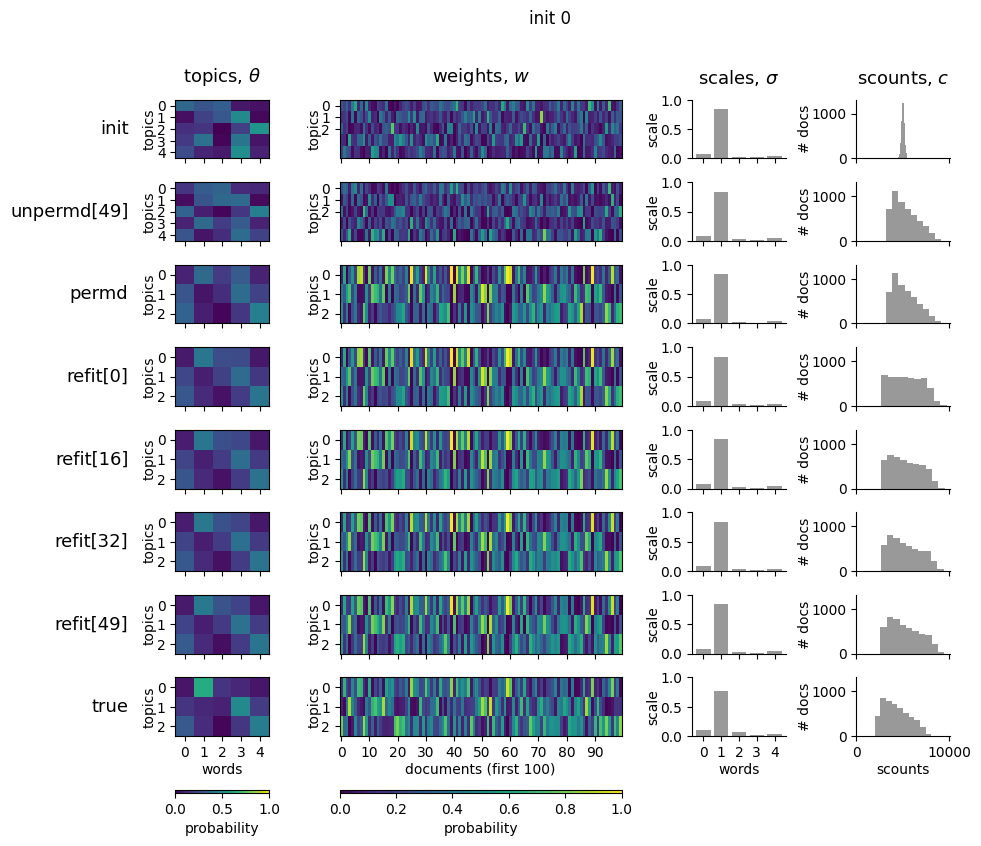

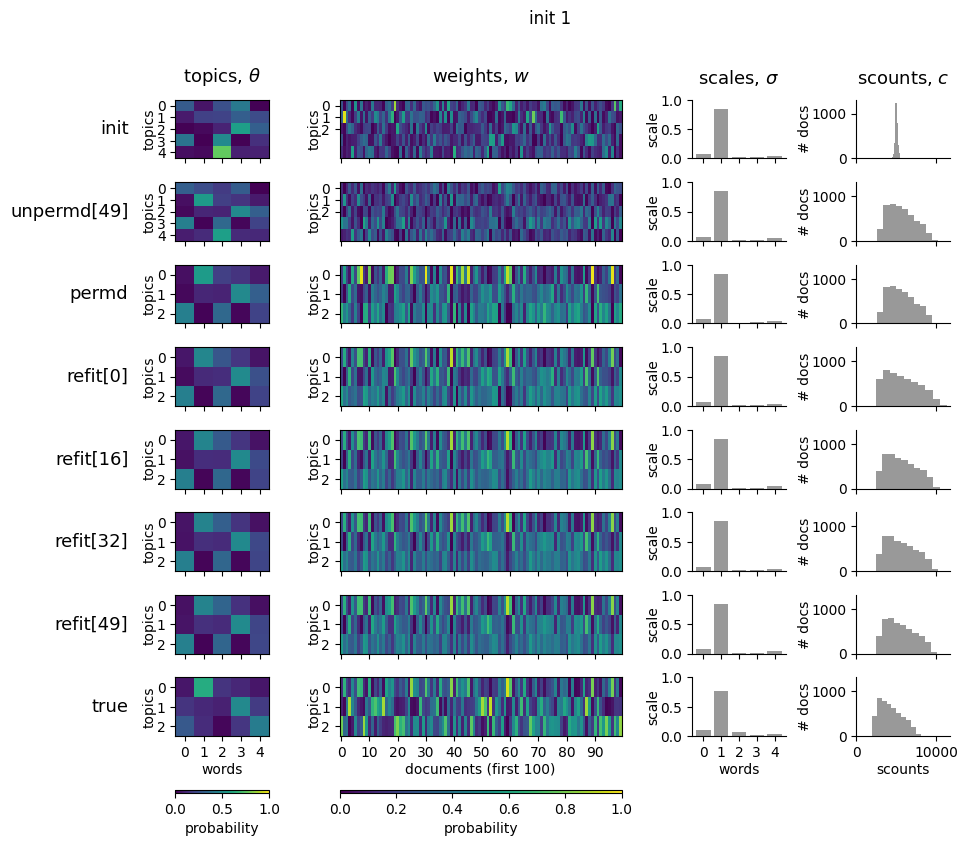

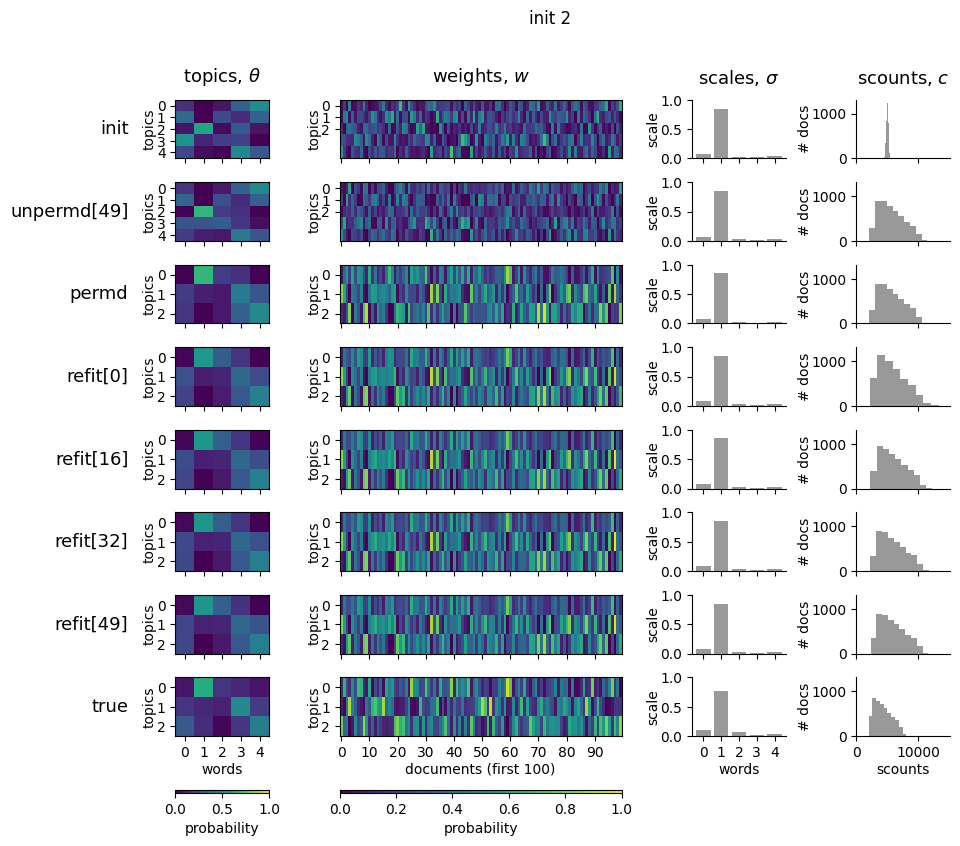

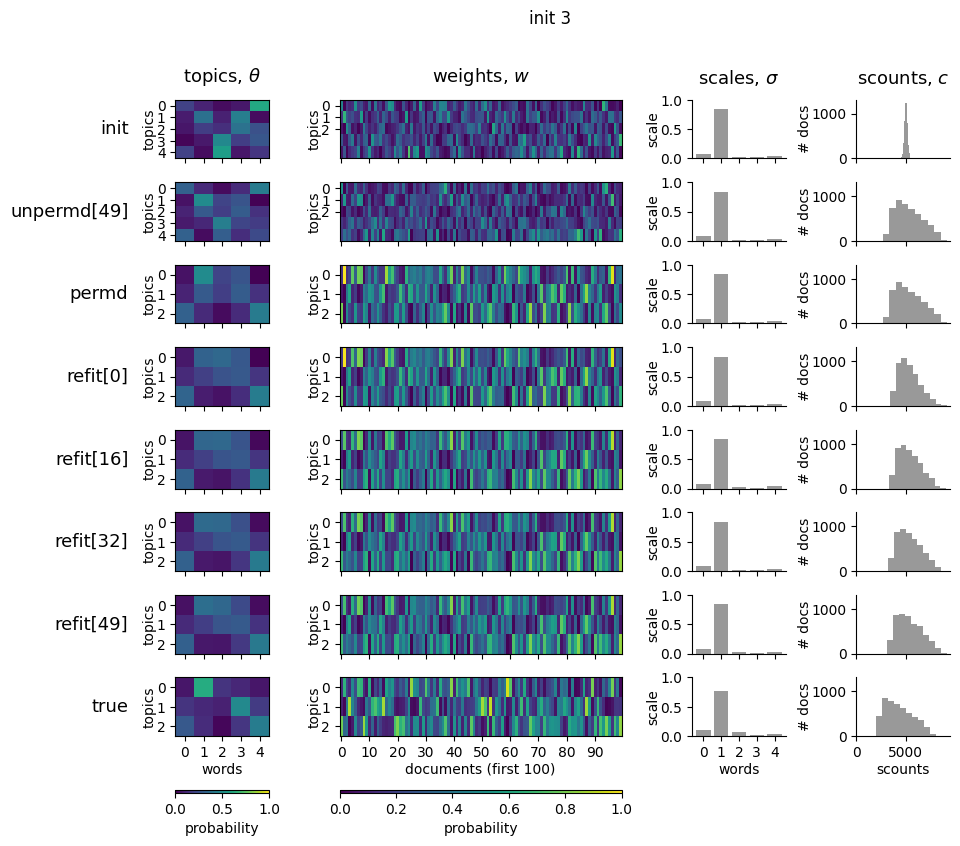

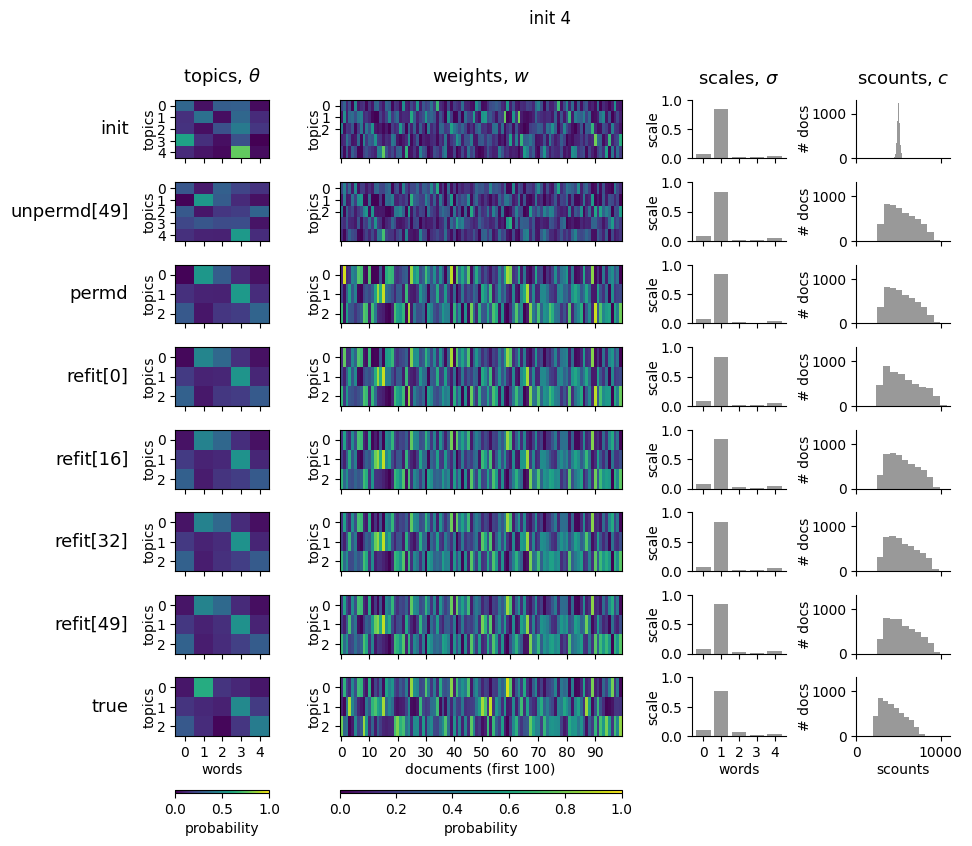

In [59]:
for i_init, (init, unpermd_by_iter, permd, refit_by_iter) in enumerate(
    zip(init_params, params_by_iter, permd_params, refit_params_by_iter)
):
    fig = compare_params({
        'init': init,
        **{f'unpermd[{i}]': unpermd_by_iter[i] for i in (len(unpermd_by_iter)-1,)},
        'permd': permd,
        **{f'refit[{i}]': refit_by_iter[i] for i in jnp.linspace(0, len(refit_by_iter)-1, num=4, dtype=int)},
        'true': true_params
    })
    fig.suptitle(f'init {i_init}')
    

10


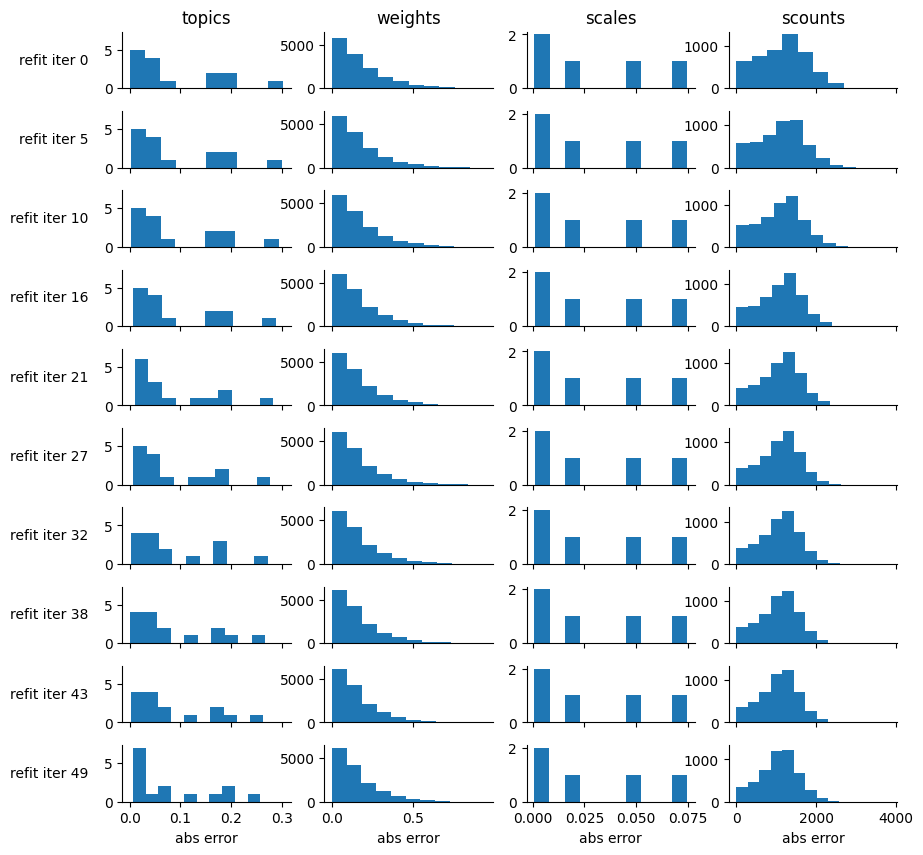

In [74]:
_params_by_iter = refit_params_by_iter[3]  # init 0 had best ll, init 3 had worst ll

i_iters = jnp.linspace(0, len(_params_by_iter)-1, num=10, dtype=int)
n_iters = len(i_iters)
print(n_iters)
fig, axs = plt.subplots(
    nrows=n_iters, ncols=4, figsize=(10, 1*n_iters),
    gridspec_kw={'hspace': 0.4},
    sharex='col', sharey='col',
)

for i, itr in enumerate(i_iters):
    for ax, a, b in zip(axs[i], true_params, _params_by_iter[itr]):
        err = jnp.abs(a-b).ravel()
        ax.hist(err)

# Label columns
for ax, name in zip(axs[0], ('topics', 'weights', 'scales', 'scounts')):
    ax.set_title(name)

# Label rows
for i, (ax, itr) in enumerate(zip(axs[:,0], i_iters)):
    ax.text(-0.2, 0.5, f"refit iter {itr}", ha='right', va='center', transform=ax.transAxes)

# Label x_axes
for ax in axs[-1]:
    ax.set_xlabel('abs error')

sns.despine()

### Prune the best "topics", without knowing true paramerters

In [76]:
params_init_fit = [_params_by_iter[-1] for _params_by_iter in params_by_iter]

**A. Find most similar topics across different inits**

AttributeError: 'list' object has no attribute 'topics'

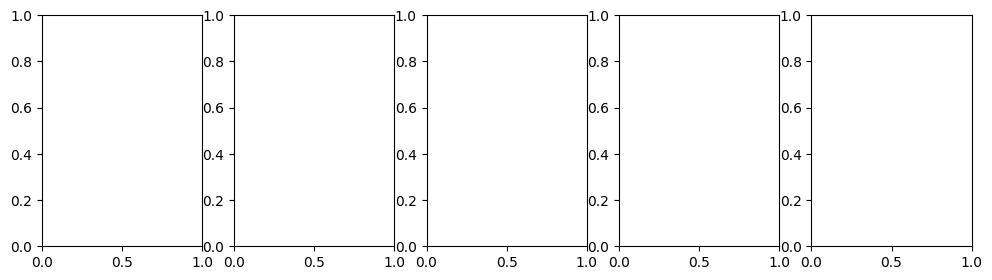

In [ ]:
fig, axs = plt.subplots(ncols=n_inits, figsize=(12,3))

params = params_by_iter[0]
axs[0].imshow(params.topics, vmin=0, vmax=1)

for ax, params_2 in zip(axs[1:], params_by_iter[1:]):
    cost_mat = cdist(params.topics, params_2.topics, metric='jensenshannon')
    _, i_perm = linear_sum_assignment(cost_mat)
    
    ax.imshow(params_2[i_perm])
    ax.set_yticks(range(n_topics))
    ax.set_yticklabels(i_perm)


**B. Cycling through topics and evaluate "leave-one-out" log likelihood**

Let's evaluate how "important" each topic is by holding out and looking at the drop in log likelihood.

In [84]:
# How circular shift works
tmp = jnp.arange(n_topics)
for k in range(n_topics):
    _tmp = jnp.roll(tmp,k)
    print(f"{k=}: working with {_tmp[:-1]}, leaving out {_tmp[-1]}")

k=0: working with [0 1 2 3], leaving out 4
k=1: working with [4 0 1 2], leaving out 3
k=2: working with [3 4 0 1], leaving out 2
k=3: working with [2 3 4 0], leaving out 1
k=4: working with [1 2 3 4], leaving out 0


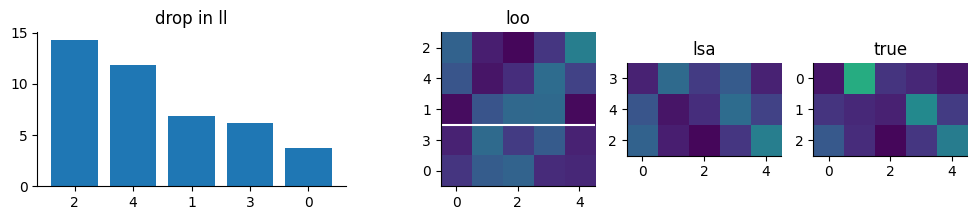

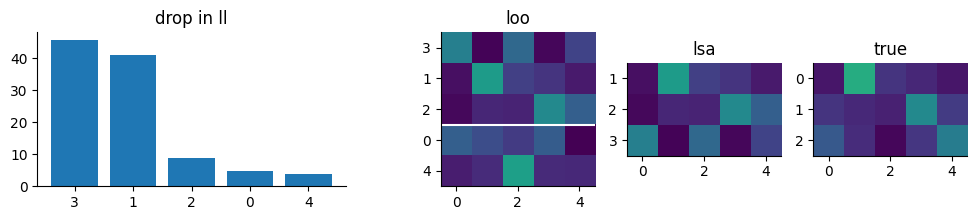

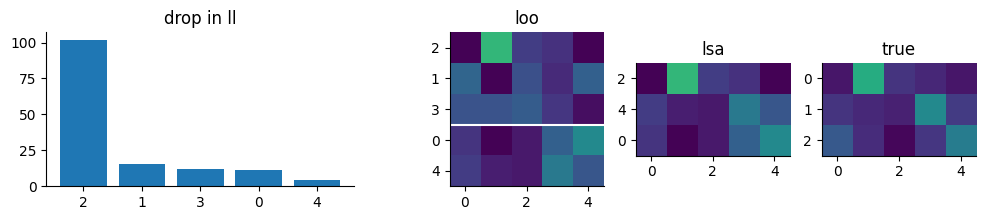

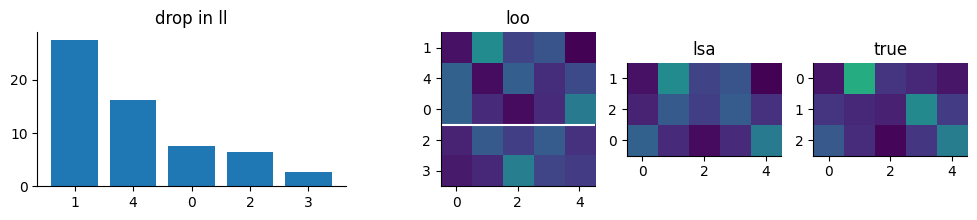

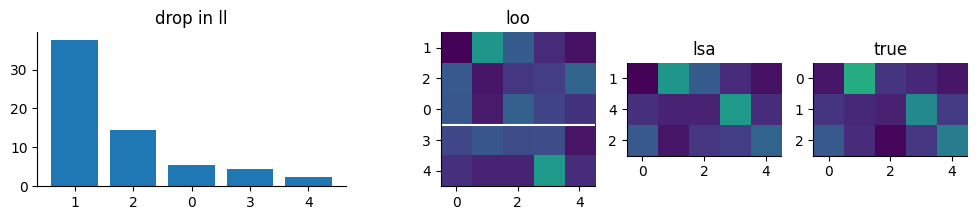

In [129]:
def multinomial_ll(topics, weights, scales):
        probs = scales * (weights @ topics)
        probs /= probs.sum(axis=-1, keepdims=True)

        return tfd.Multinomial(data.sum(axis=-1), probs=probs).log_prob(data).mean()

for i_init, (params, lsa_perm) in enumerate(zip(params_init_fit, perms)):
    topics, weights, scales, _ = params
    refr_ll = multinomial_ll(topics, weights, scales)
    
    n_topics = len(topics)

    loo_lls = []
    for k in range(n_topics):
        _topics = jnp.roll(topics, k, axis=0)[:-1]
        
        _weights = jnp.roll(weights, k, axis=1)[:, :-1]
        _weights /= _weights.sum(axis=-1, keepdims=True) # restandardize weights; no significant effect in ordering

        loo_ll = multinomial_ll(_topics, _weights, scales)

        loo_lls.append(loo_ll)

    loo_lls = jnp.array(loo_lls[::-1])
    
    # sort by greatest difference from refrence ll
    diff = refr_ll - loo_lls
    loo_perm = jnp.argsort(diff)[::-1]

    fig, axs = plt.subplots(
        ncols=5, width_ratios=[2,0.2, 1,1,1], figsize=(12, 2)
    )
    axs[1].remove()
    loo_ax = axs[0]
    mat_axs = axs[2:]

    # plot loo
    ax = loo_ax
    ax.bar(range(n_topics), diff[loo_perm])
    ax.set_xticks(range(n_topics))
    ax.set_xticklabels(loo_perm)
    ax.set_title(f"drop in ll")

    # plot mats
    for ax, name, perm in zip(mat_axs[:-1], ('loo', 'lsa'), (loo_perm, lsa_perm)):
        ax.imshow(topics[perm], vmin=0, vmax=1)
        ax.set_yticks(range(len(perm)))
        ax.set_yticklabels(perm)
        ax.set_title(name)
    mat_axs[0].axhline(2.5, color='w')  # draw cut off for loo mats

    ax = axs[-1]
    ax.imshow(true_params.topics, vmin=0, vmax=1)
    ax.set_title('true')
    sns.despine()

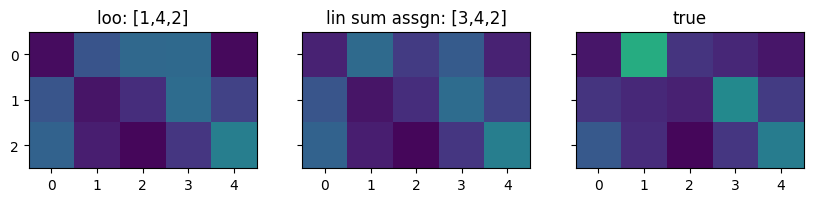

In [119]:
topics_dict = {
    "loo: [1,4,2]": topics[jnp.array([1,4,2])],
    "lin sum assgn: [3,4,2]": topics[jnp.array([3,4,2])],
    "true": true_params.topics,
}

fig, axs = plt.subplots(ncols=len(topics_dict), sharex=True, sharey=True, figsize=(10,3))

for ax, (name, mat) in zip(axs, topics_dict.items()):
    ax.imshow(mat, vmin=0, vmax=1)
    ax.set_title(name)

### Look at topic similarities within a fit??

Text(0.5, 1.05, 'pairwise jensen-shannon distance')

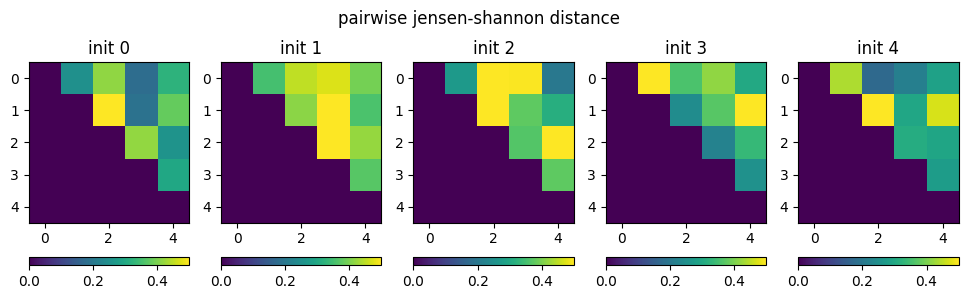

In [153]:
from scipy.spatial.distance import pdist, squareform
fig, axs = plt.subplots(ncols=n_inits, figsize=(12,3))

for i_init, (params, lsa_perm) in enumerate(zip(params_init_fit, perms)):
    topics, weights, scales, _ = params
    cost_matrix = onp.triu(squareform(pdist(topics, metric='jensenshannon')))

    ax = axs[i_init]
    im = ax.imshow(cost_matrix, vmin=0, vmax=0.5)
    ax.set_title(f'init {i_init}')
    plt.colorbar(im, ax=ax, location='bottom', pad=0.15)

fig.suptitle('pairwise jensen-shannon distance', y=1.05)
